In [10]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np

from multiobjective_opt.mab.agents import UCB, EpsGreedy
from multiobjective_opt.mab.environment import ArmEnv
from multiobjective_opt.mab.runner import RunAlgEnv

from multiobjective_opt.synthetic_exp.mab_classes import FuncArm, FuncRewardEstimator

from multiobjective_opt.synthetic_exp.drawer import plot_results

from multiobjective_opt.synthetic_exp.function_handler import JaxFunc

from multiobjective_opt.synthetic_exp.optimizers import (
    AcceleratedGradDescent,
    Constraints,
    SGMTripleAveraging,
)
from multiobjective_opt.utils.utils import savefig
from scipy.optimize import Bounds

import os


SAVEPATH = Path("../exp_results/figures")
def save_figures(figs):
    # exp_results/figures
    for f_name, fig in figs.items():
        path = SAVEPATH / "stochastic"
        if not path.exists():
            os.mkdir(path)
        f_name = f"{f_name}"
        savefig(fig, path, f_name)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## не стохастический градиент

В этом эксперименте рассмотрим функции с доступом к точному градиенту.

Среди функций будут сильно выпуклые, гладкие выпуклые и негладкие выпуклые. 

1) Для сильно реализуется ускоренный градиентный спуск сходимостью $1/t^2$.
3) Для негладких применим технику сглаживания и получим сходимость порядка $1/t^{0.5}$

In [11]:
UCB = EpsGreedy


## smooth arms

In [12]:
from multiobjective_opt.synthetic_exp.functions import (
    ModularFunc,
    QuadFormSQRT,
)


def get_QuadFormSQRT_arm(dim_smooth, min_val=None, seed = 0):
    # prepare function with optimizer for arm
    if min_val is None:
        min_val = np.random.randn()

    oracle_smooth = JaxFunc(QuadFormSQRT(dim_smooth, min_val=min_val, seed = seed), dim_smooth)
    if min_val != 0.5:
        x0 = np.ones(dim_smooth) * 2 + oracle_smooth.func.bias
    else:
        x0 = np.ones(dim_smooth) * 4.5 + oracle_smooth.func.bias
    L, R = oracle_smooth.func.get_params(x0)
    L = L
    smooth_optimizer = AcceleratedGradDescent(oracle_smooth, x0=x0, L=L, R=R)
    arm = FuncArm(smooth_optimizer)
    arm.name = rf"$f_{int(min_val * 2)}^*$={(min_val)}"
    return arm

In [13]:
def init_quad_arms(num_arms = 3):
    dim = 20
    arm_min_vals = np.linspace(0.5, 1.5, num=num_arms)

    arms = []

    for i in range(num_arms):
        nsm_opt = get_QuadFormSQRT_arm(dim, arm_min_vals[i], seed= int(arm_min_vals[i]))
        arms.append(nsm_opt)

    return arms, arm_min_vals

n_actions = 3

reward_estimator = FuncRewardEstimator(n_actions)
agent = UCB(n_actions, reward_estimator)

arms, min_vals = init_quad_arms(n_actions)
env = ArmEnv(arms)


runner = RunAlgEnv(env, agent)
res = runner.run(max_steps=150)

[<class 'multiobjective_opt.synthetic_exp.drawer.PlottableRes'>]


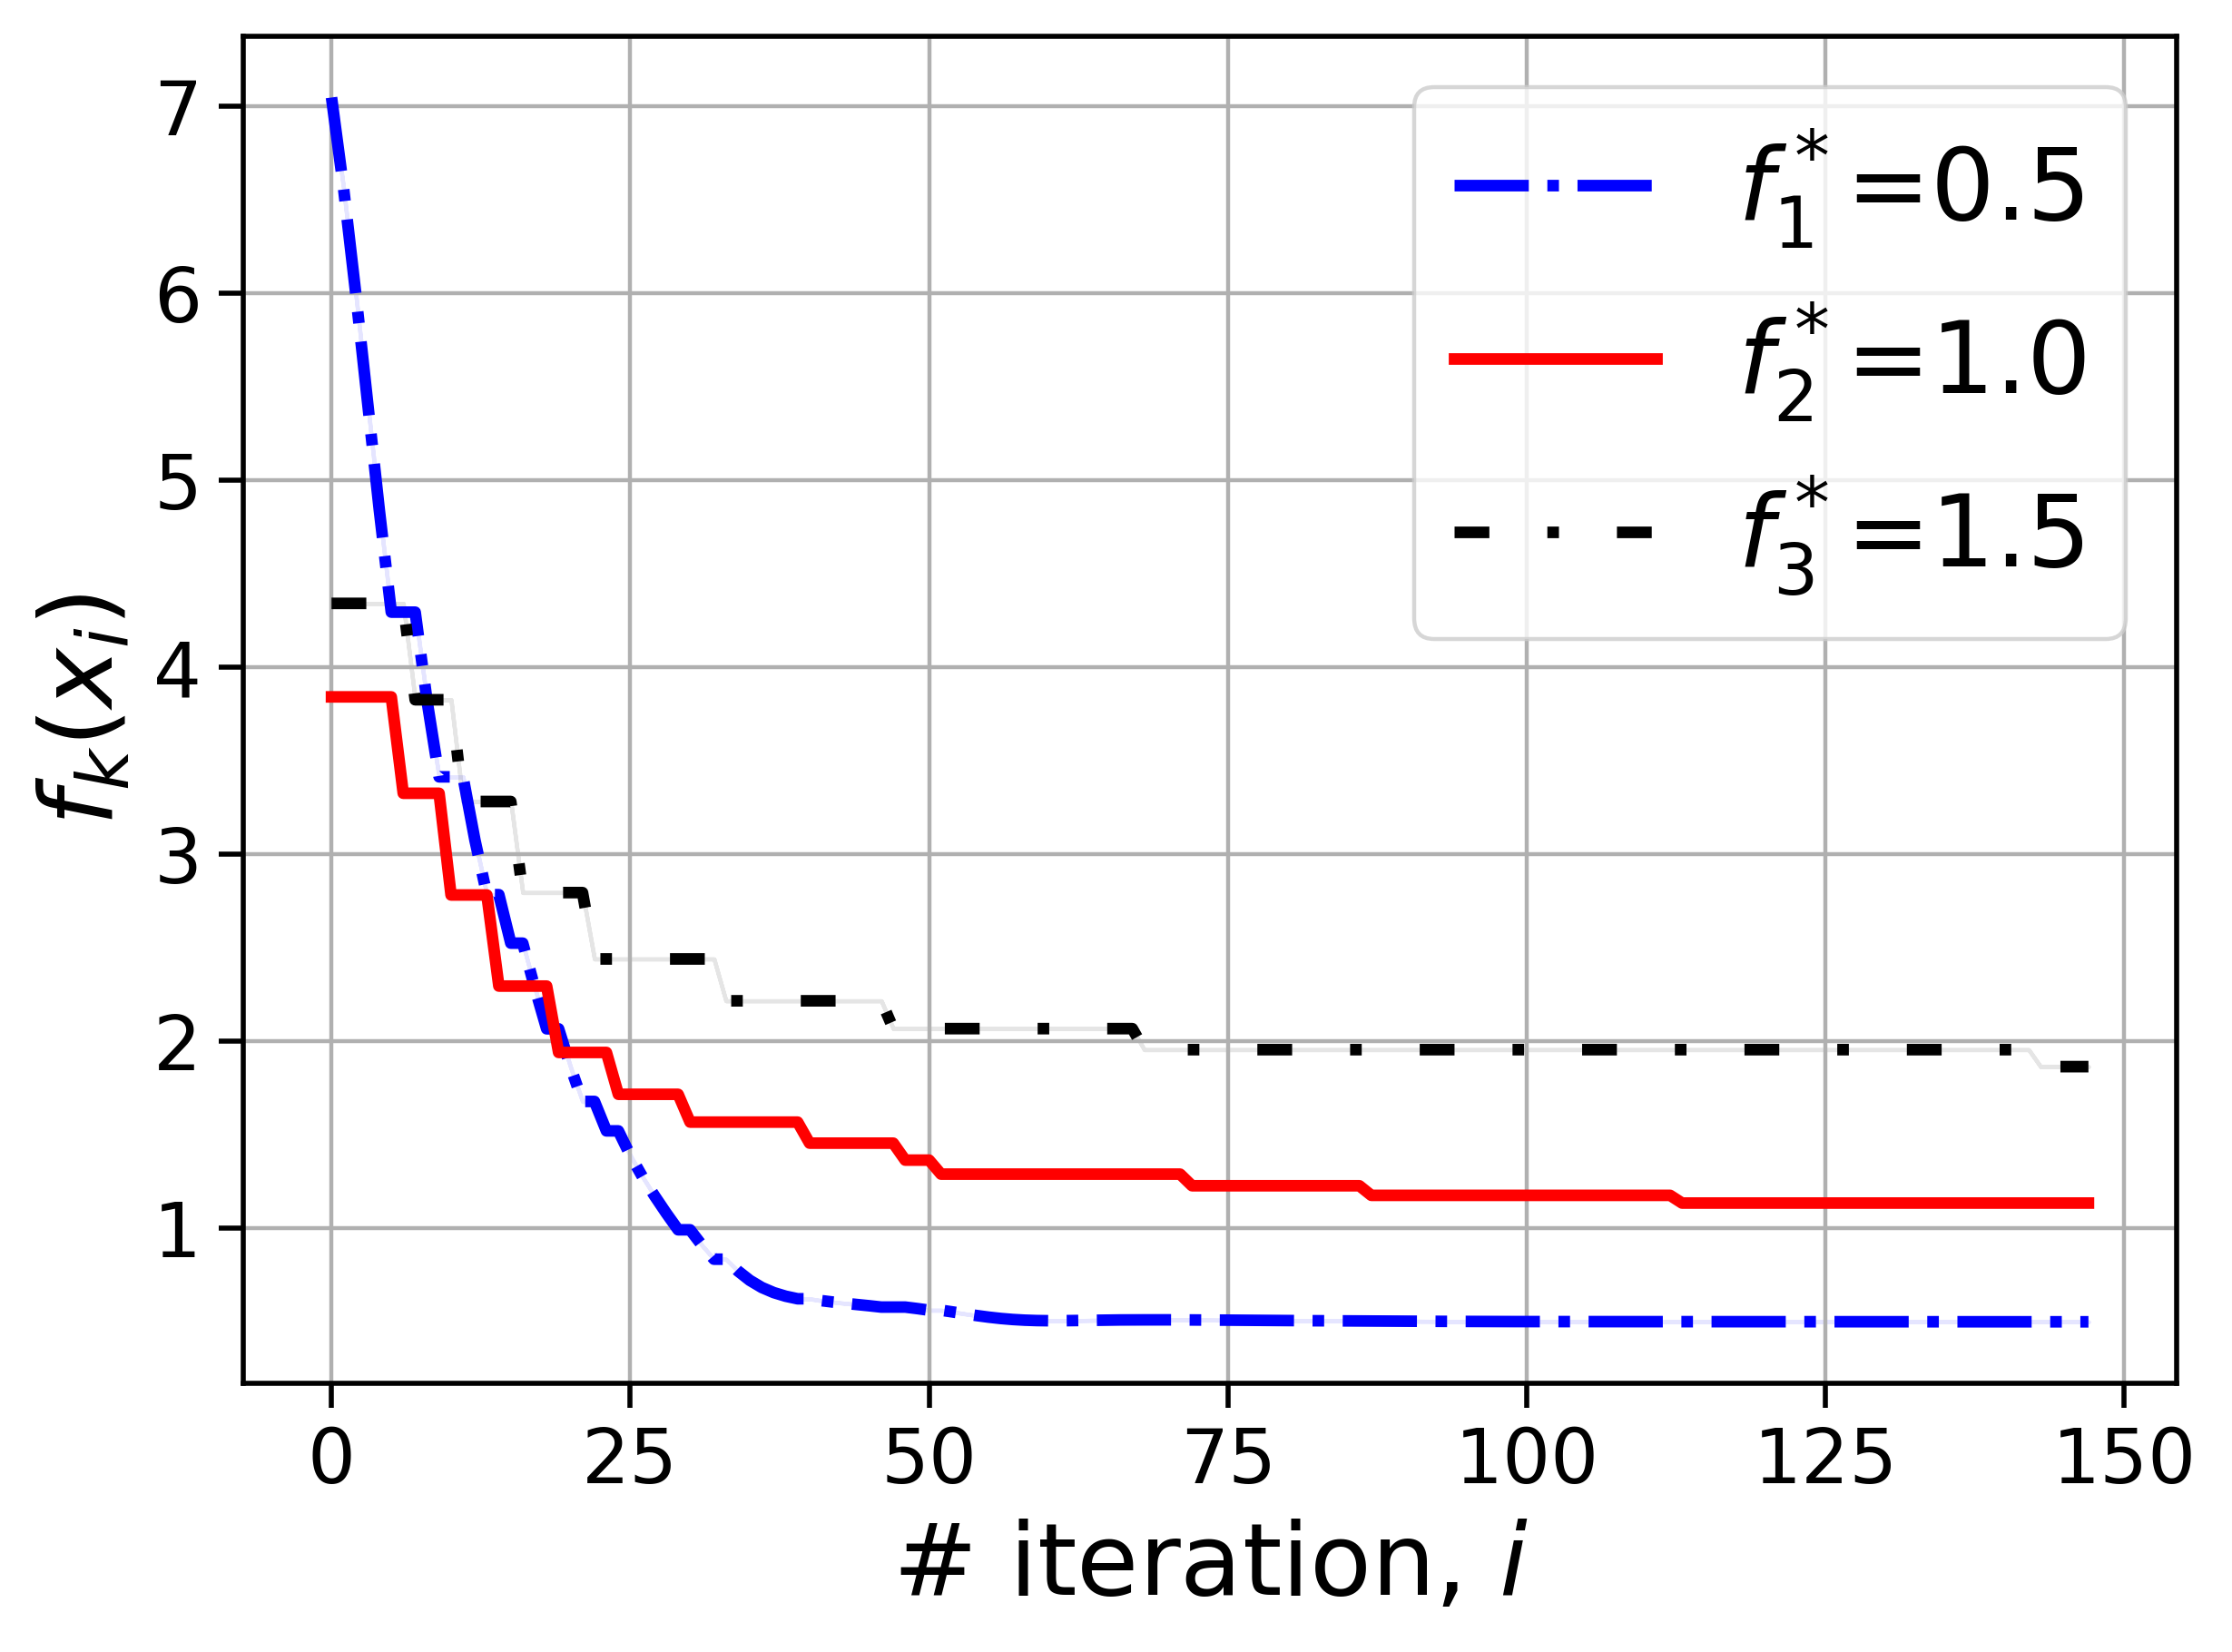

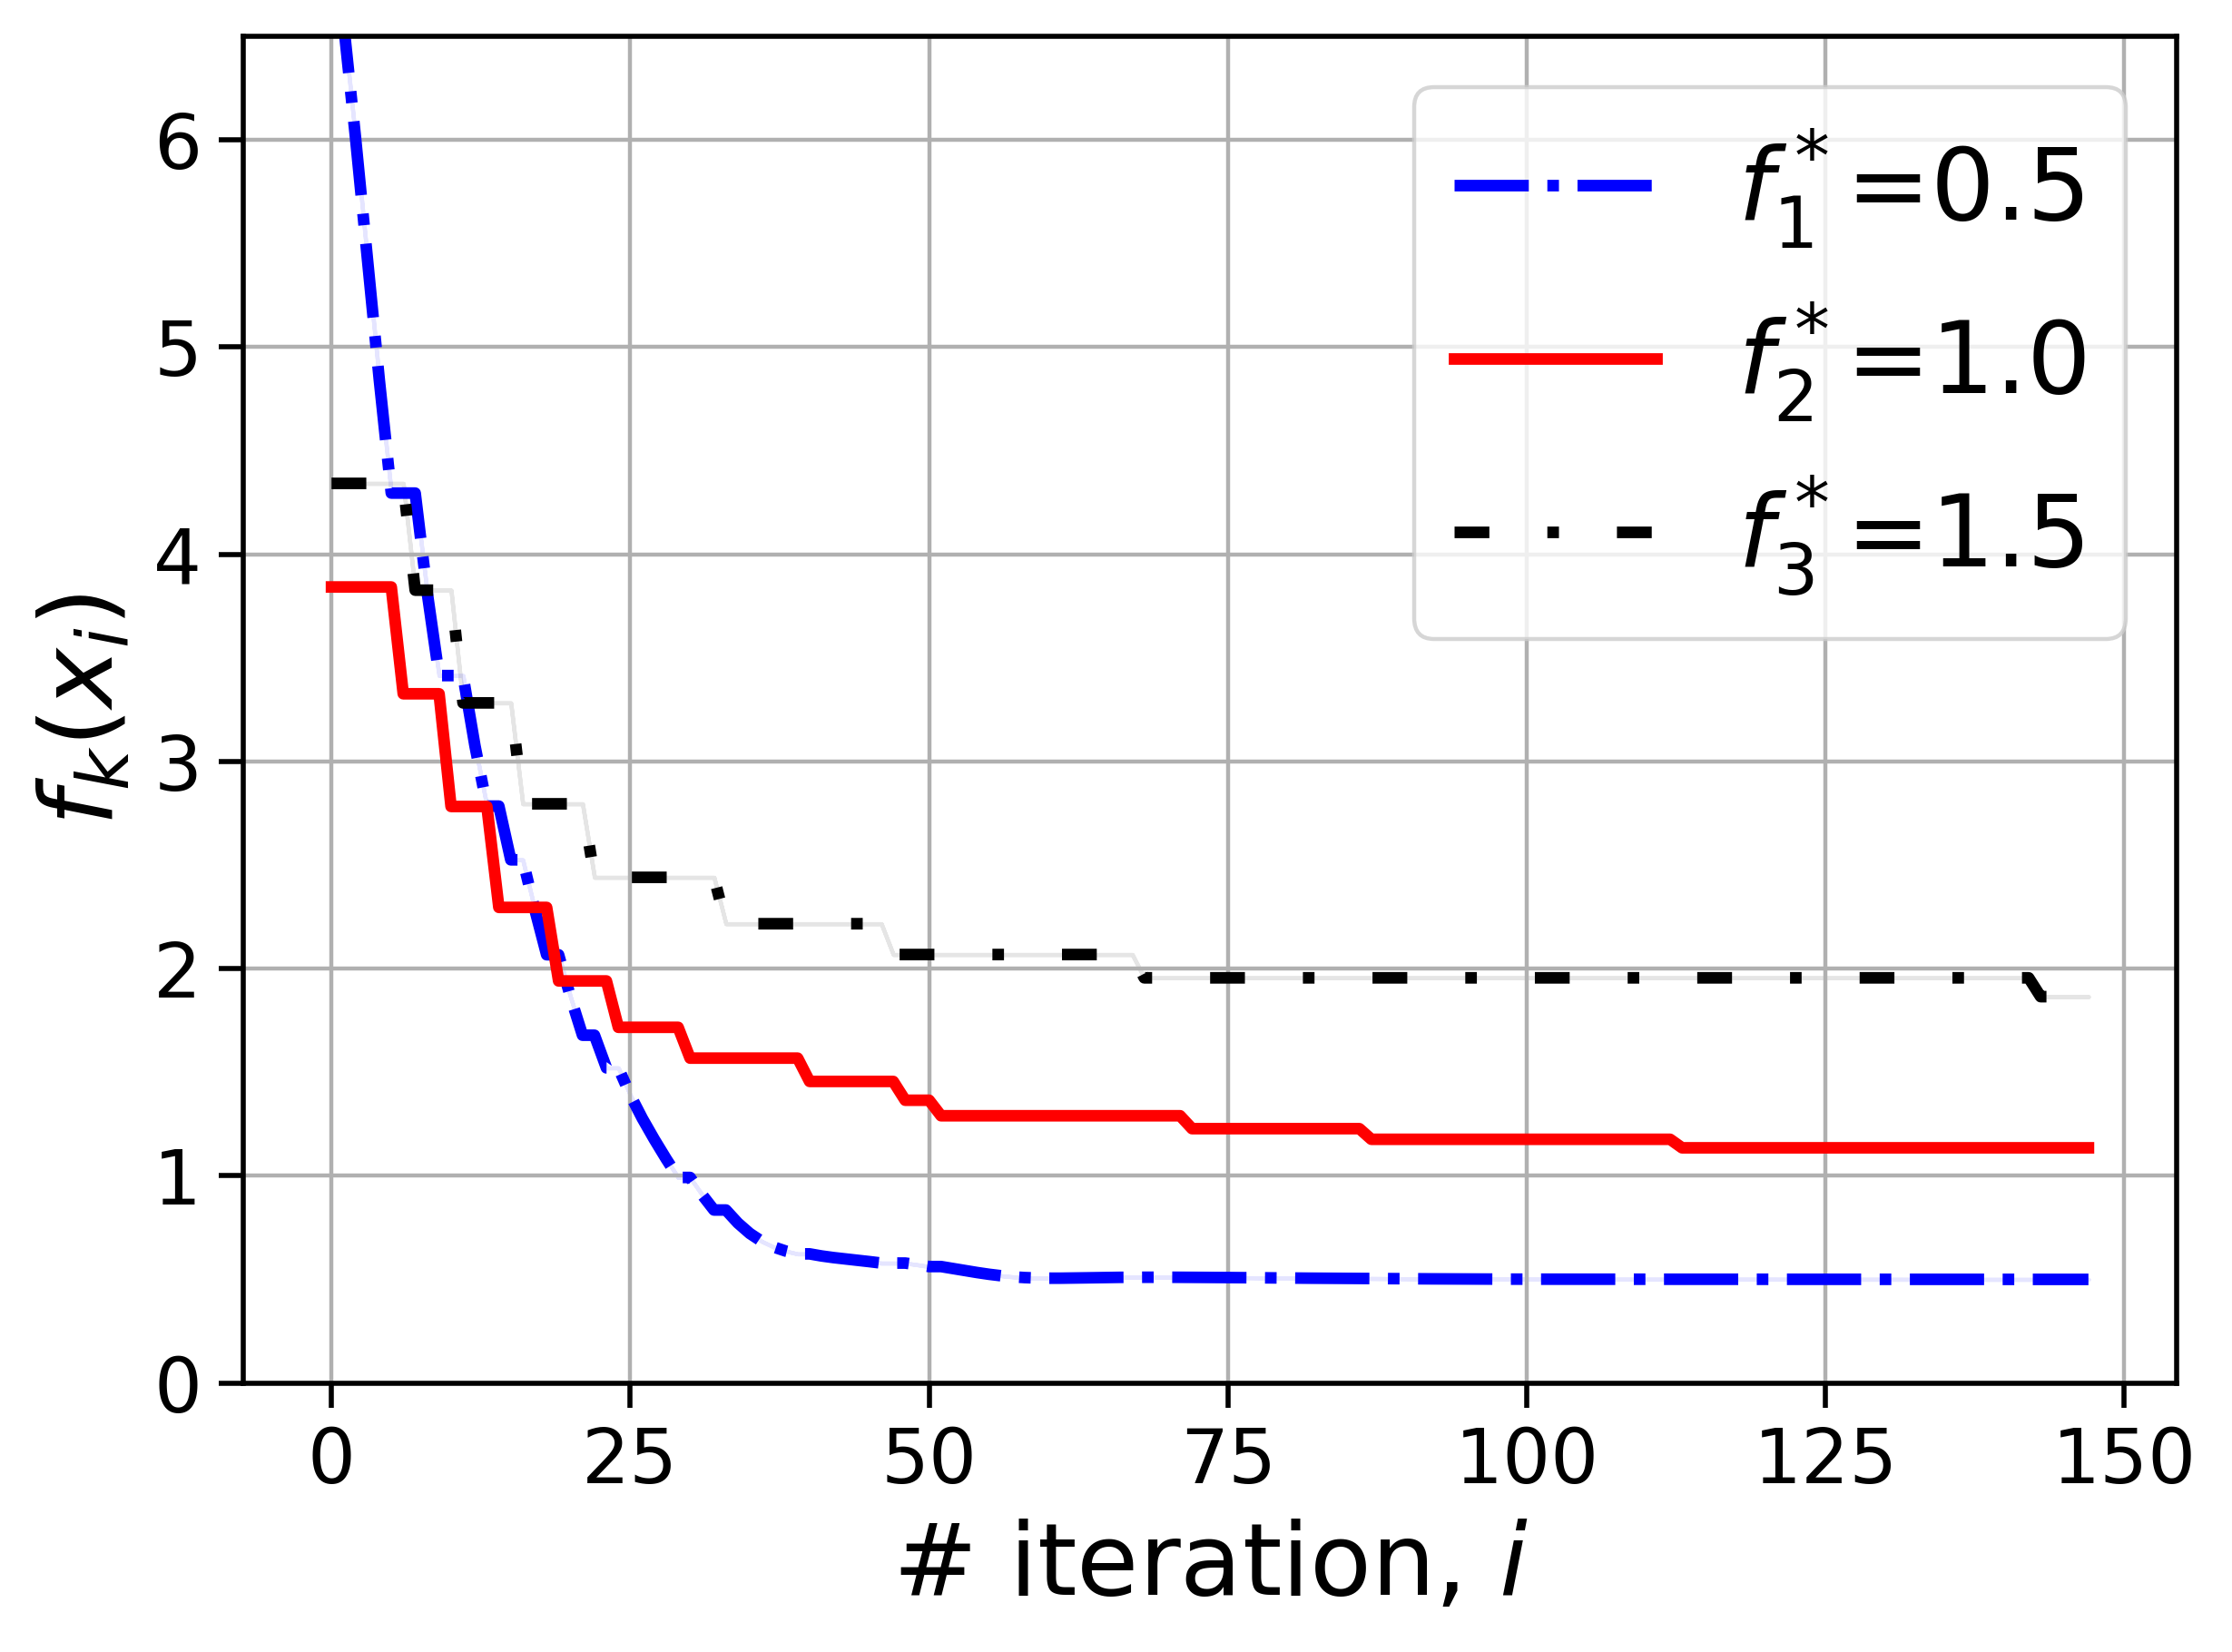

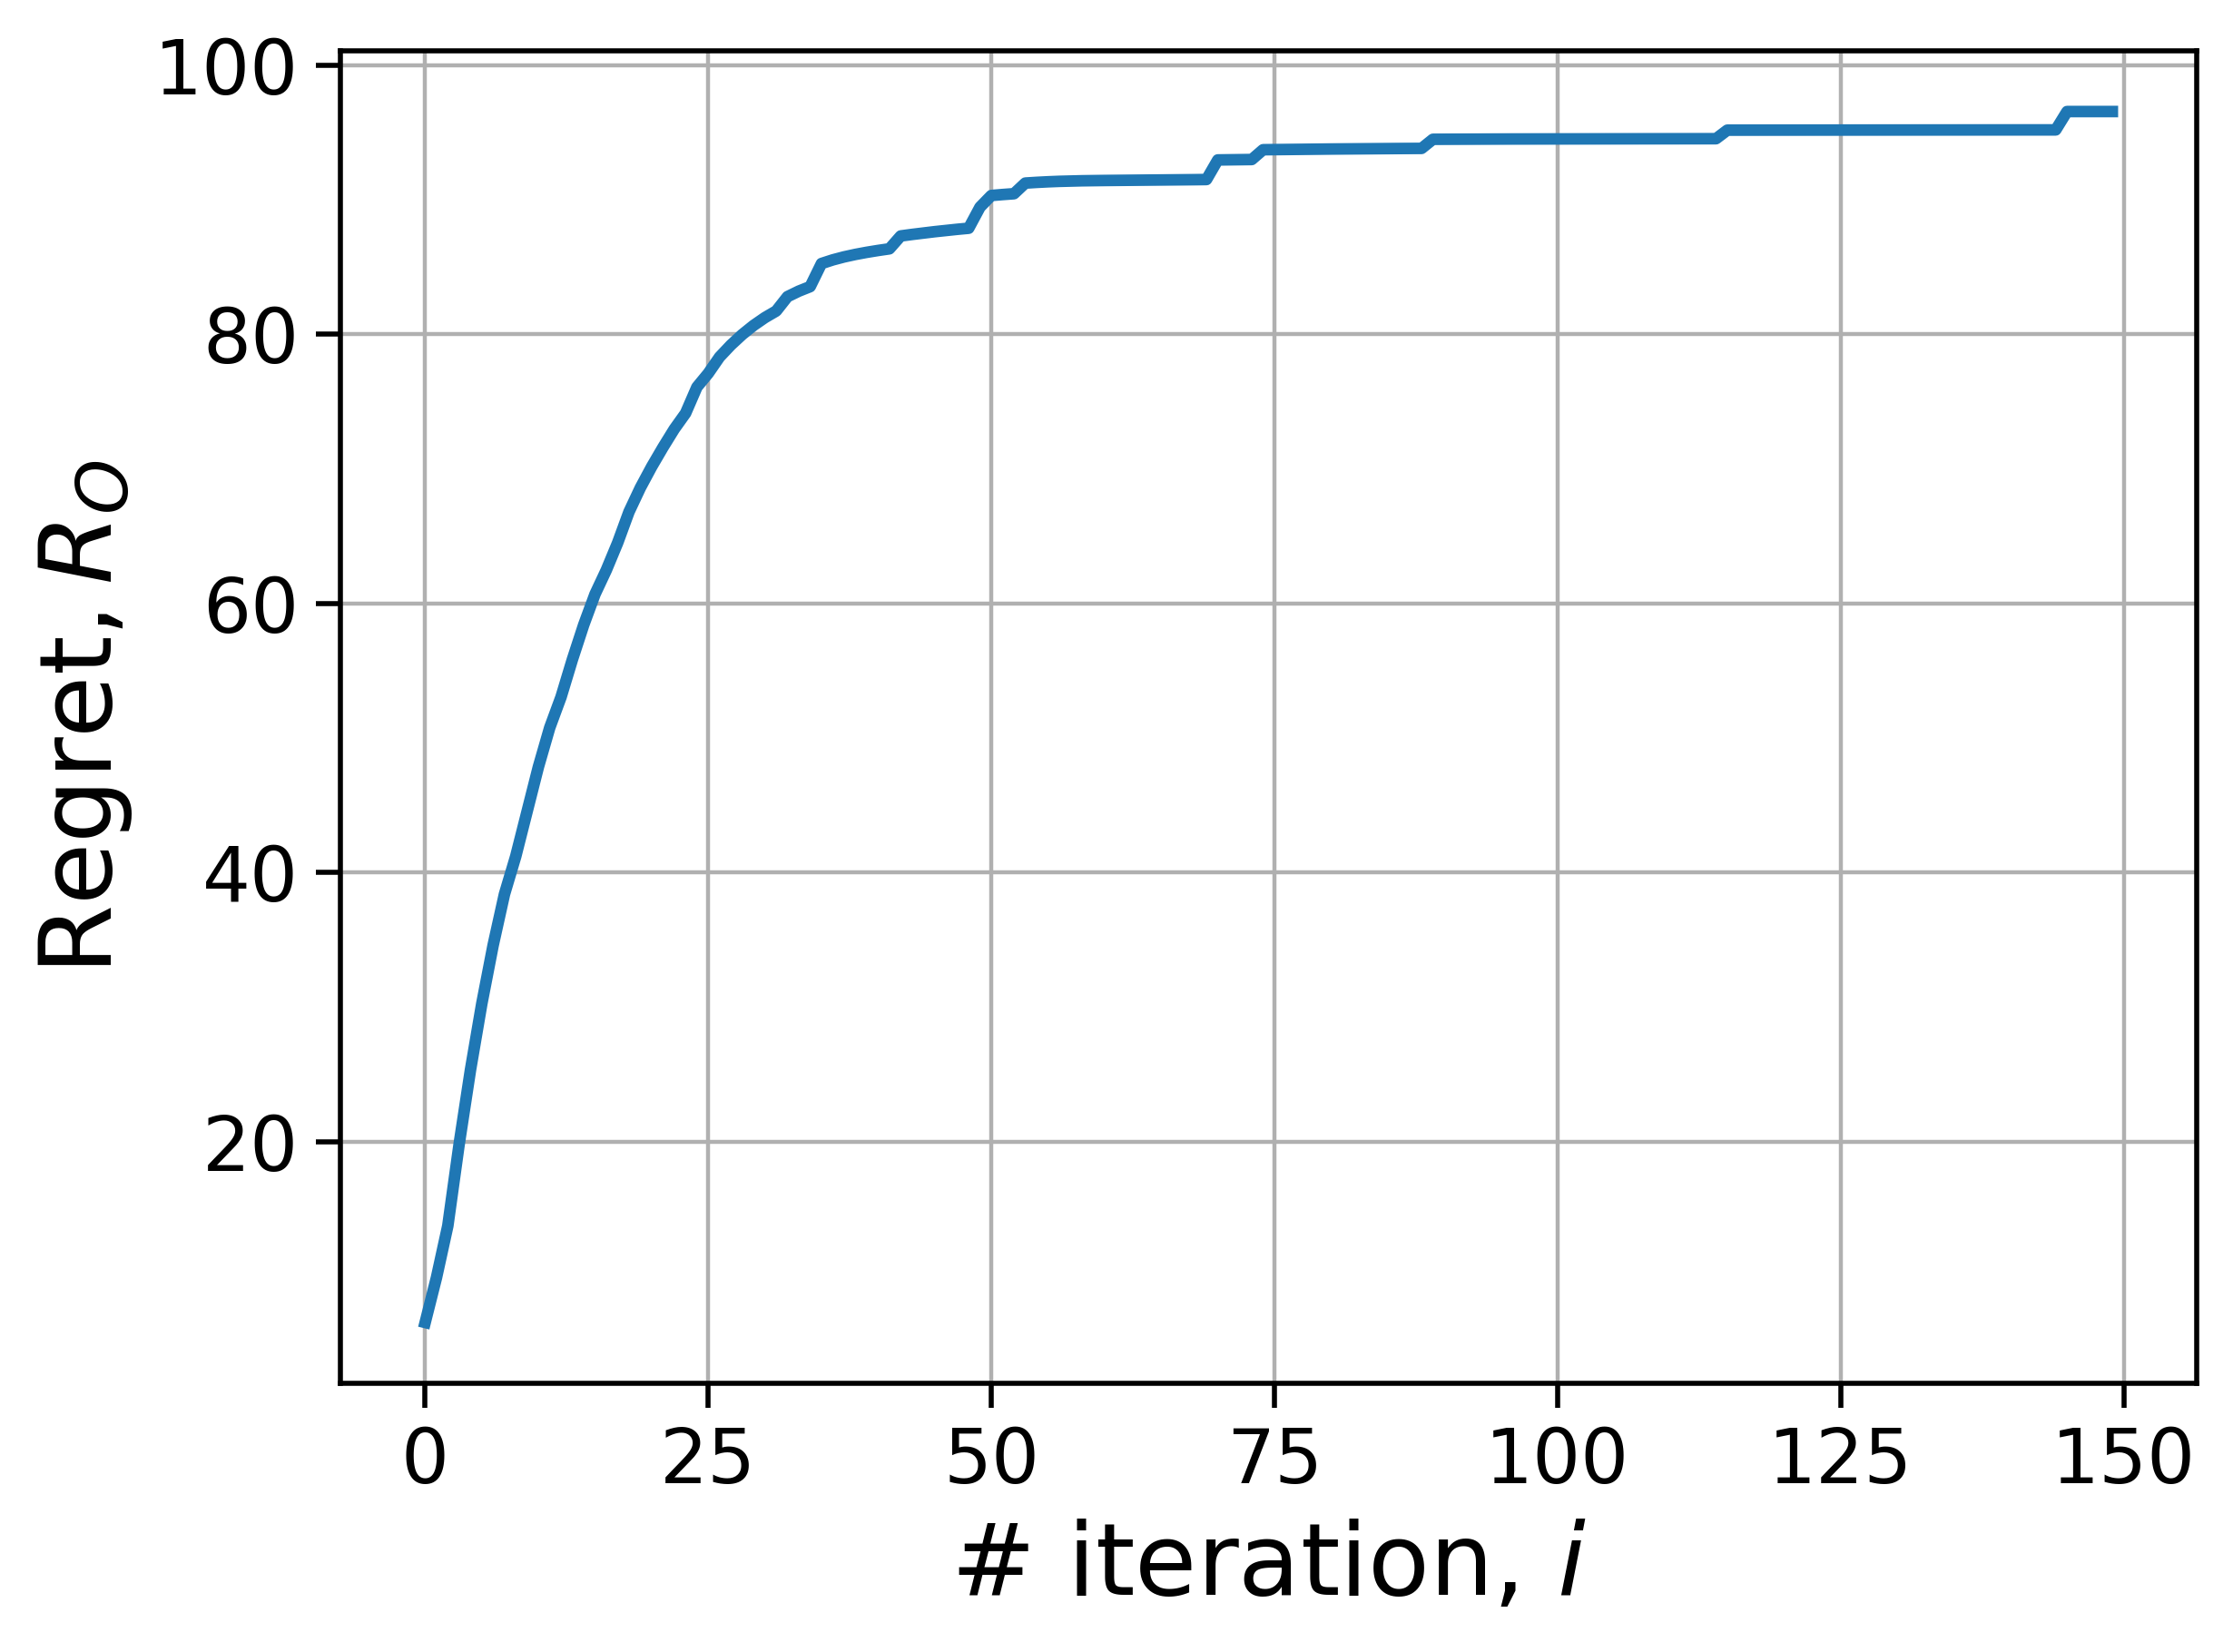

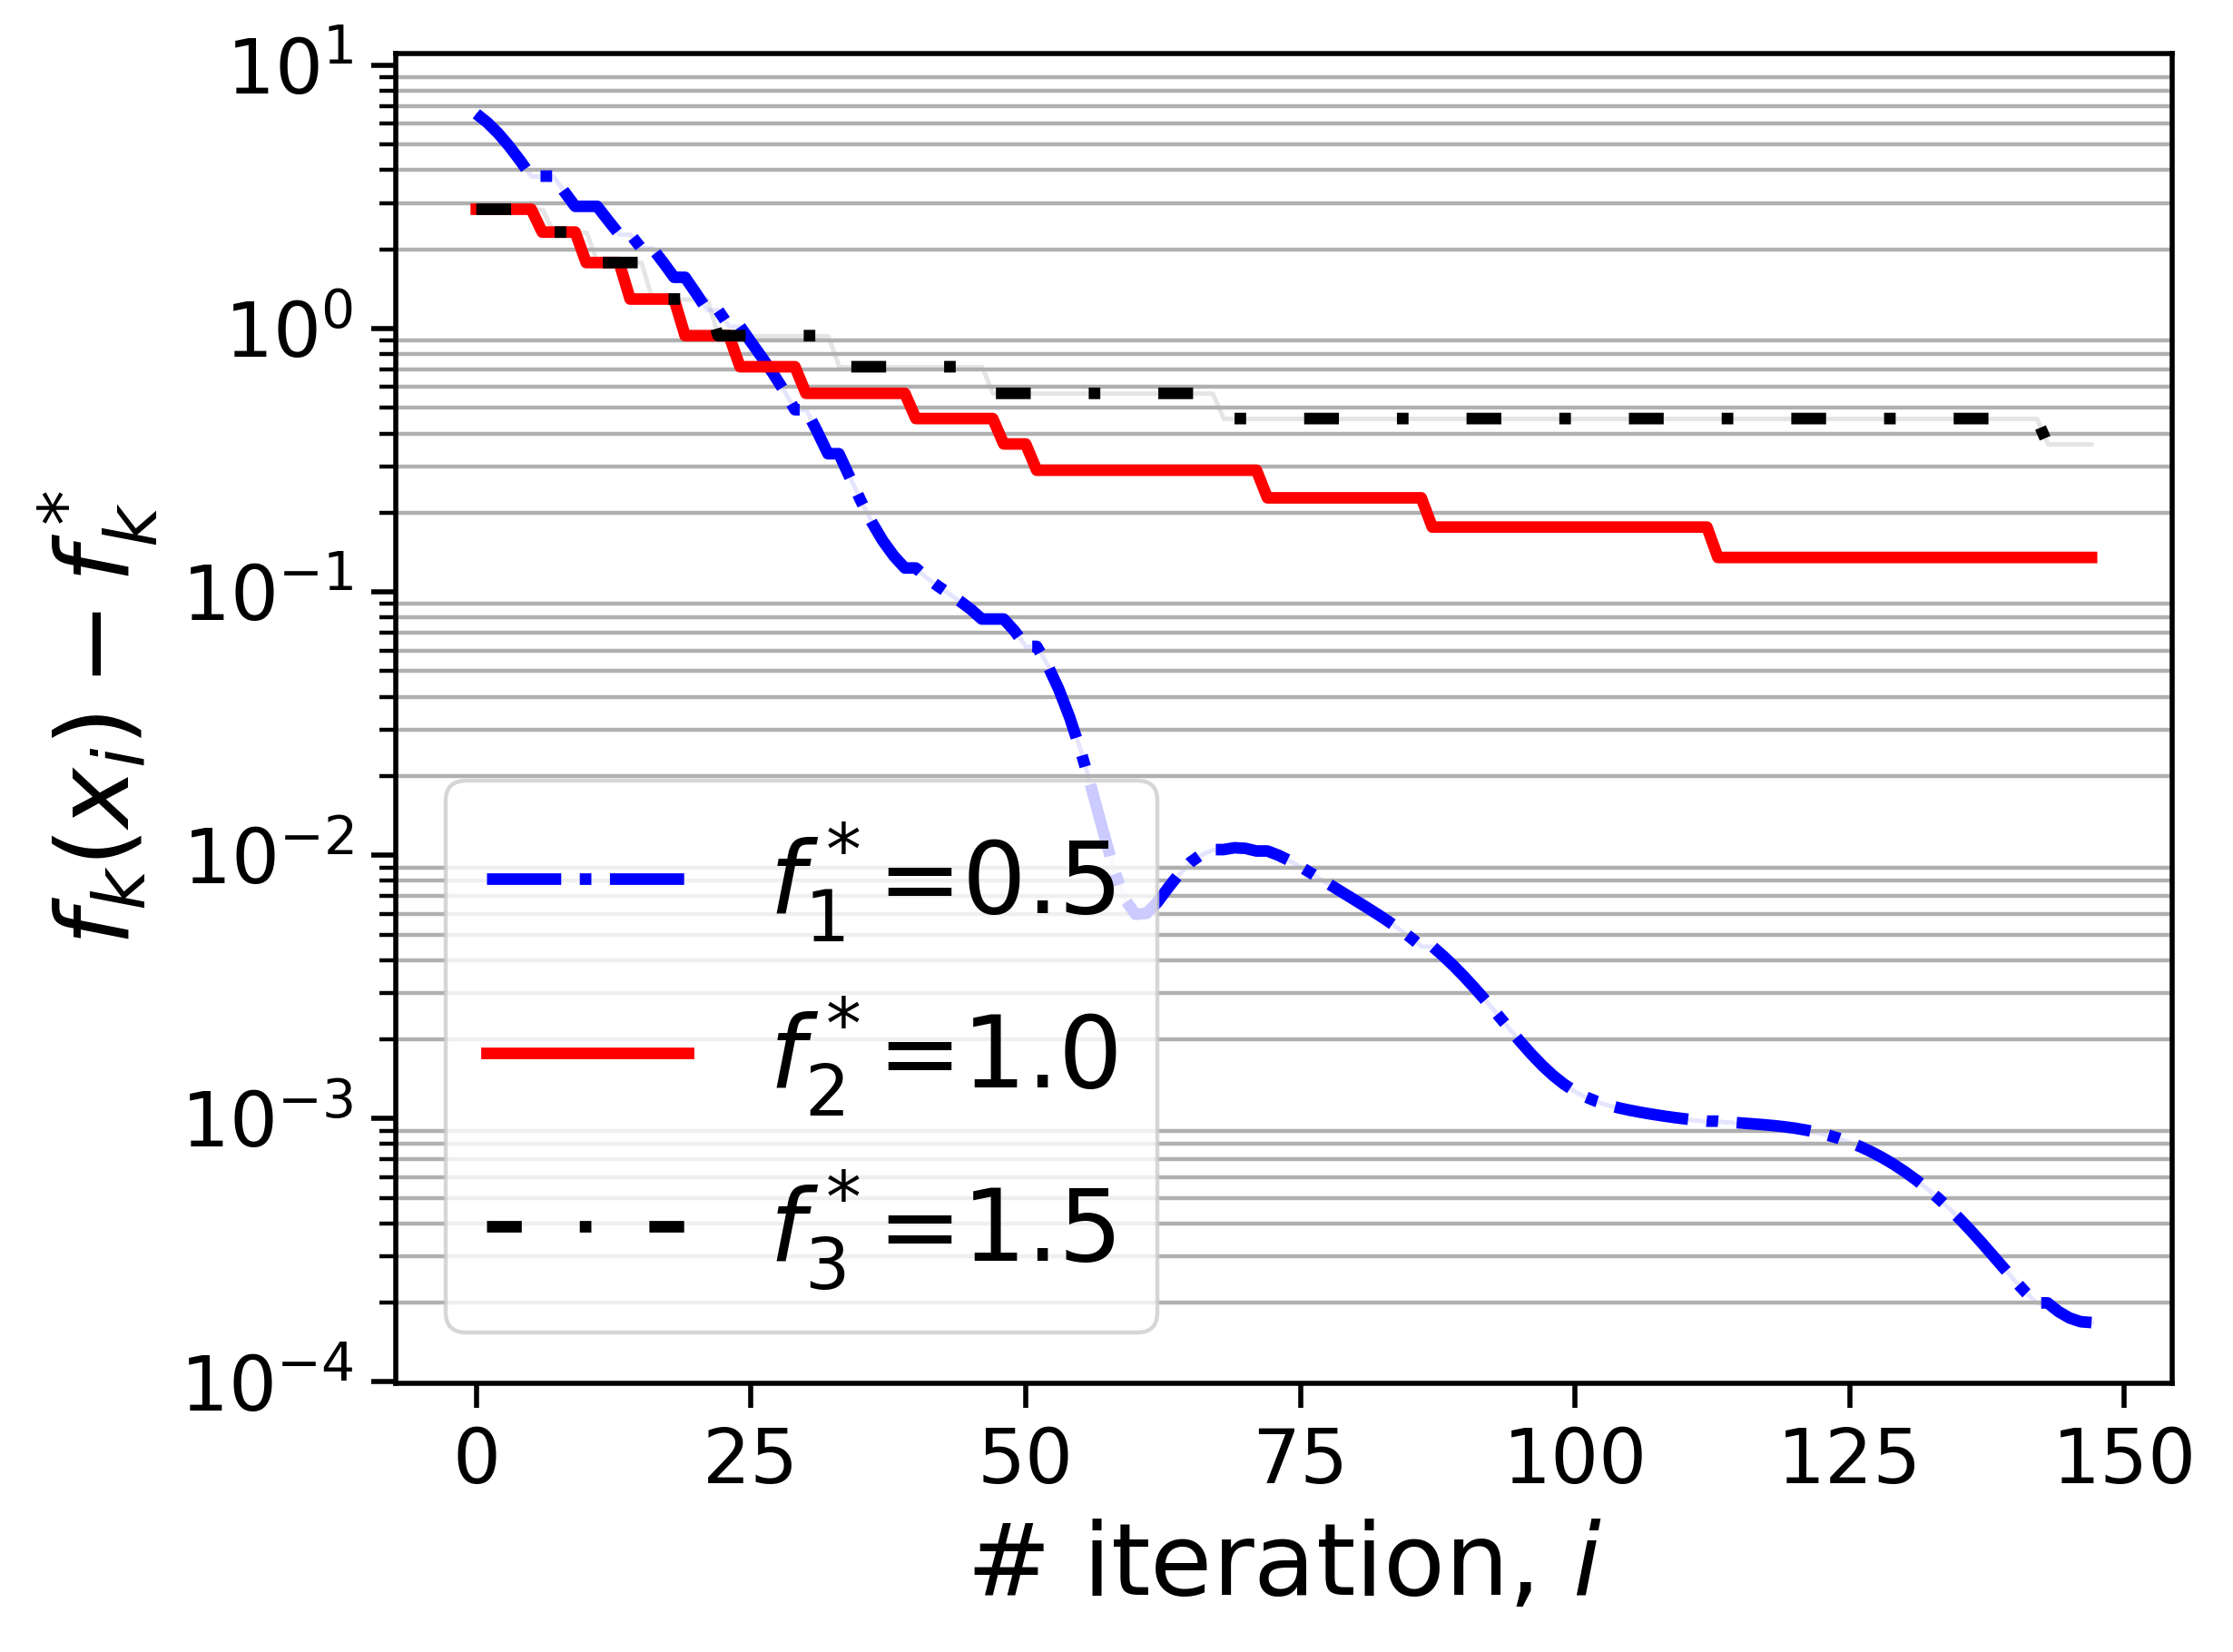

In [14]:
figs = plot_results([res], arms, min_vals, with_intervals=True)
save_figures(figs)

## nonsmooth arms

In [15]:
from multiobjective_opt.synthetic_exp.functions import (
    ModularFunc,
    QuadFormSQRT,
)

def get_nonsmooth_arm(dim_nonsmooth, min_val=None, num_planes = 5, seed = 0):
    bounds = Bounds(-np.ones(dim_nonsmooth) * 1, np.ones(dim_nonsmooth) * 1)
    projection_function = Constraints(bounds=bounds)

    if min_val is None:
        min_val = np.random.randn()

    oracle_nonsmooth = JaxFunc(
        ModularFunc(
            dim_nonsmooth, optimization_set=bounds, min_val=min_val, num_planes=num_planes,
            seed = seed
        ),
        dim_nonsmooth,
    )
    x0 = np.zeros(dim_nonsmooth)
    L_nonsmooth, R = oracle_nonsmooth.func.get_params(x0)
    # G = 8 * dim_nonsmooth**0.5
    G = R * 2
    nonsmooth_optimizer = SGMTripleAveraging(
        oracle_nonsmooth,
        projection_function=projection_function,
        gamma=L_nonsmooth,
        L=L_nonsmooth,
        G=G,
        dimension=dim_nonsmooth,
    )
    
    arm = FuncArm(nonsmooth_optimizer)
    arm.name = rf"$f_{int(min_val*2)}^*$={(min_val)}"
    return arm


In [16]:
def init_arms(nonsmooth_arms):
    dim = 20
    nonsmooth_arms = 3
    nonsmooth_arms_values = np.linspace(0.5, 1.5, num=nonsmooth_arms)
    num_planes_arm = [5, 10, 12]
    arms = []

    for i in range(nonsmooth_arms):
        nsm_opt = get_nonsmooth_arm(dim, 
                                nonsmooth_arms_values[i],
                                num_planes = num_planes_arm[i], 
                                seed= int(nonsmooth_arms_values[i]) + int(num_planes_arm[i]))
        arms.append(nsm_opt)
    return arms, nonsmooth_arms_values


n_actions = 3

reward_estimator = FuncRewardEstimator(n_actions)
agent = UCB(n_actions, reward_estimator)

arms, min_vals = init_arms(n_actions)
env = ArmEnv(arms)

runner = RunAlgEnv(env, agent)
res = runner.run(max_steps=1000)

-11.720912253178374
-6.306642484668894
-4.435807154061854


[<class 'multiobjective_opt.synthetic_exp.drawer.PlottableRes'>]


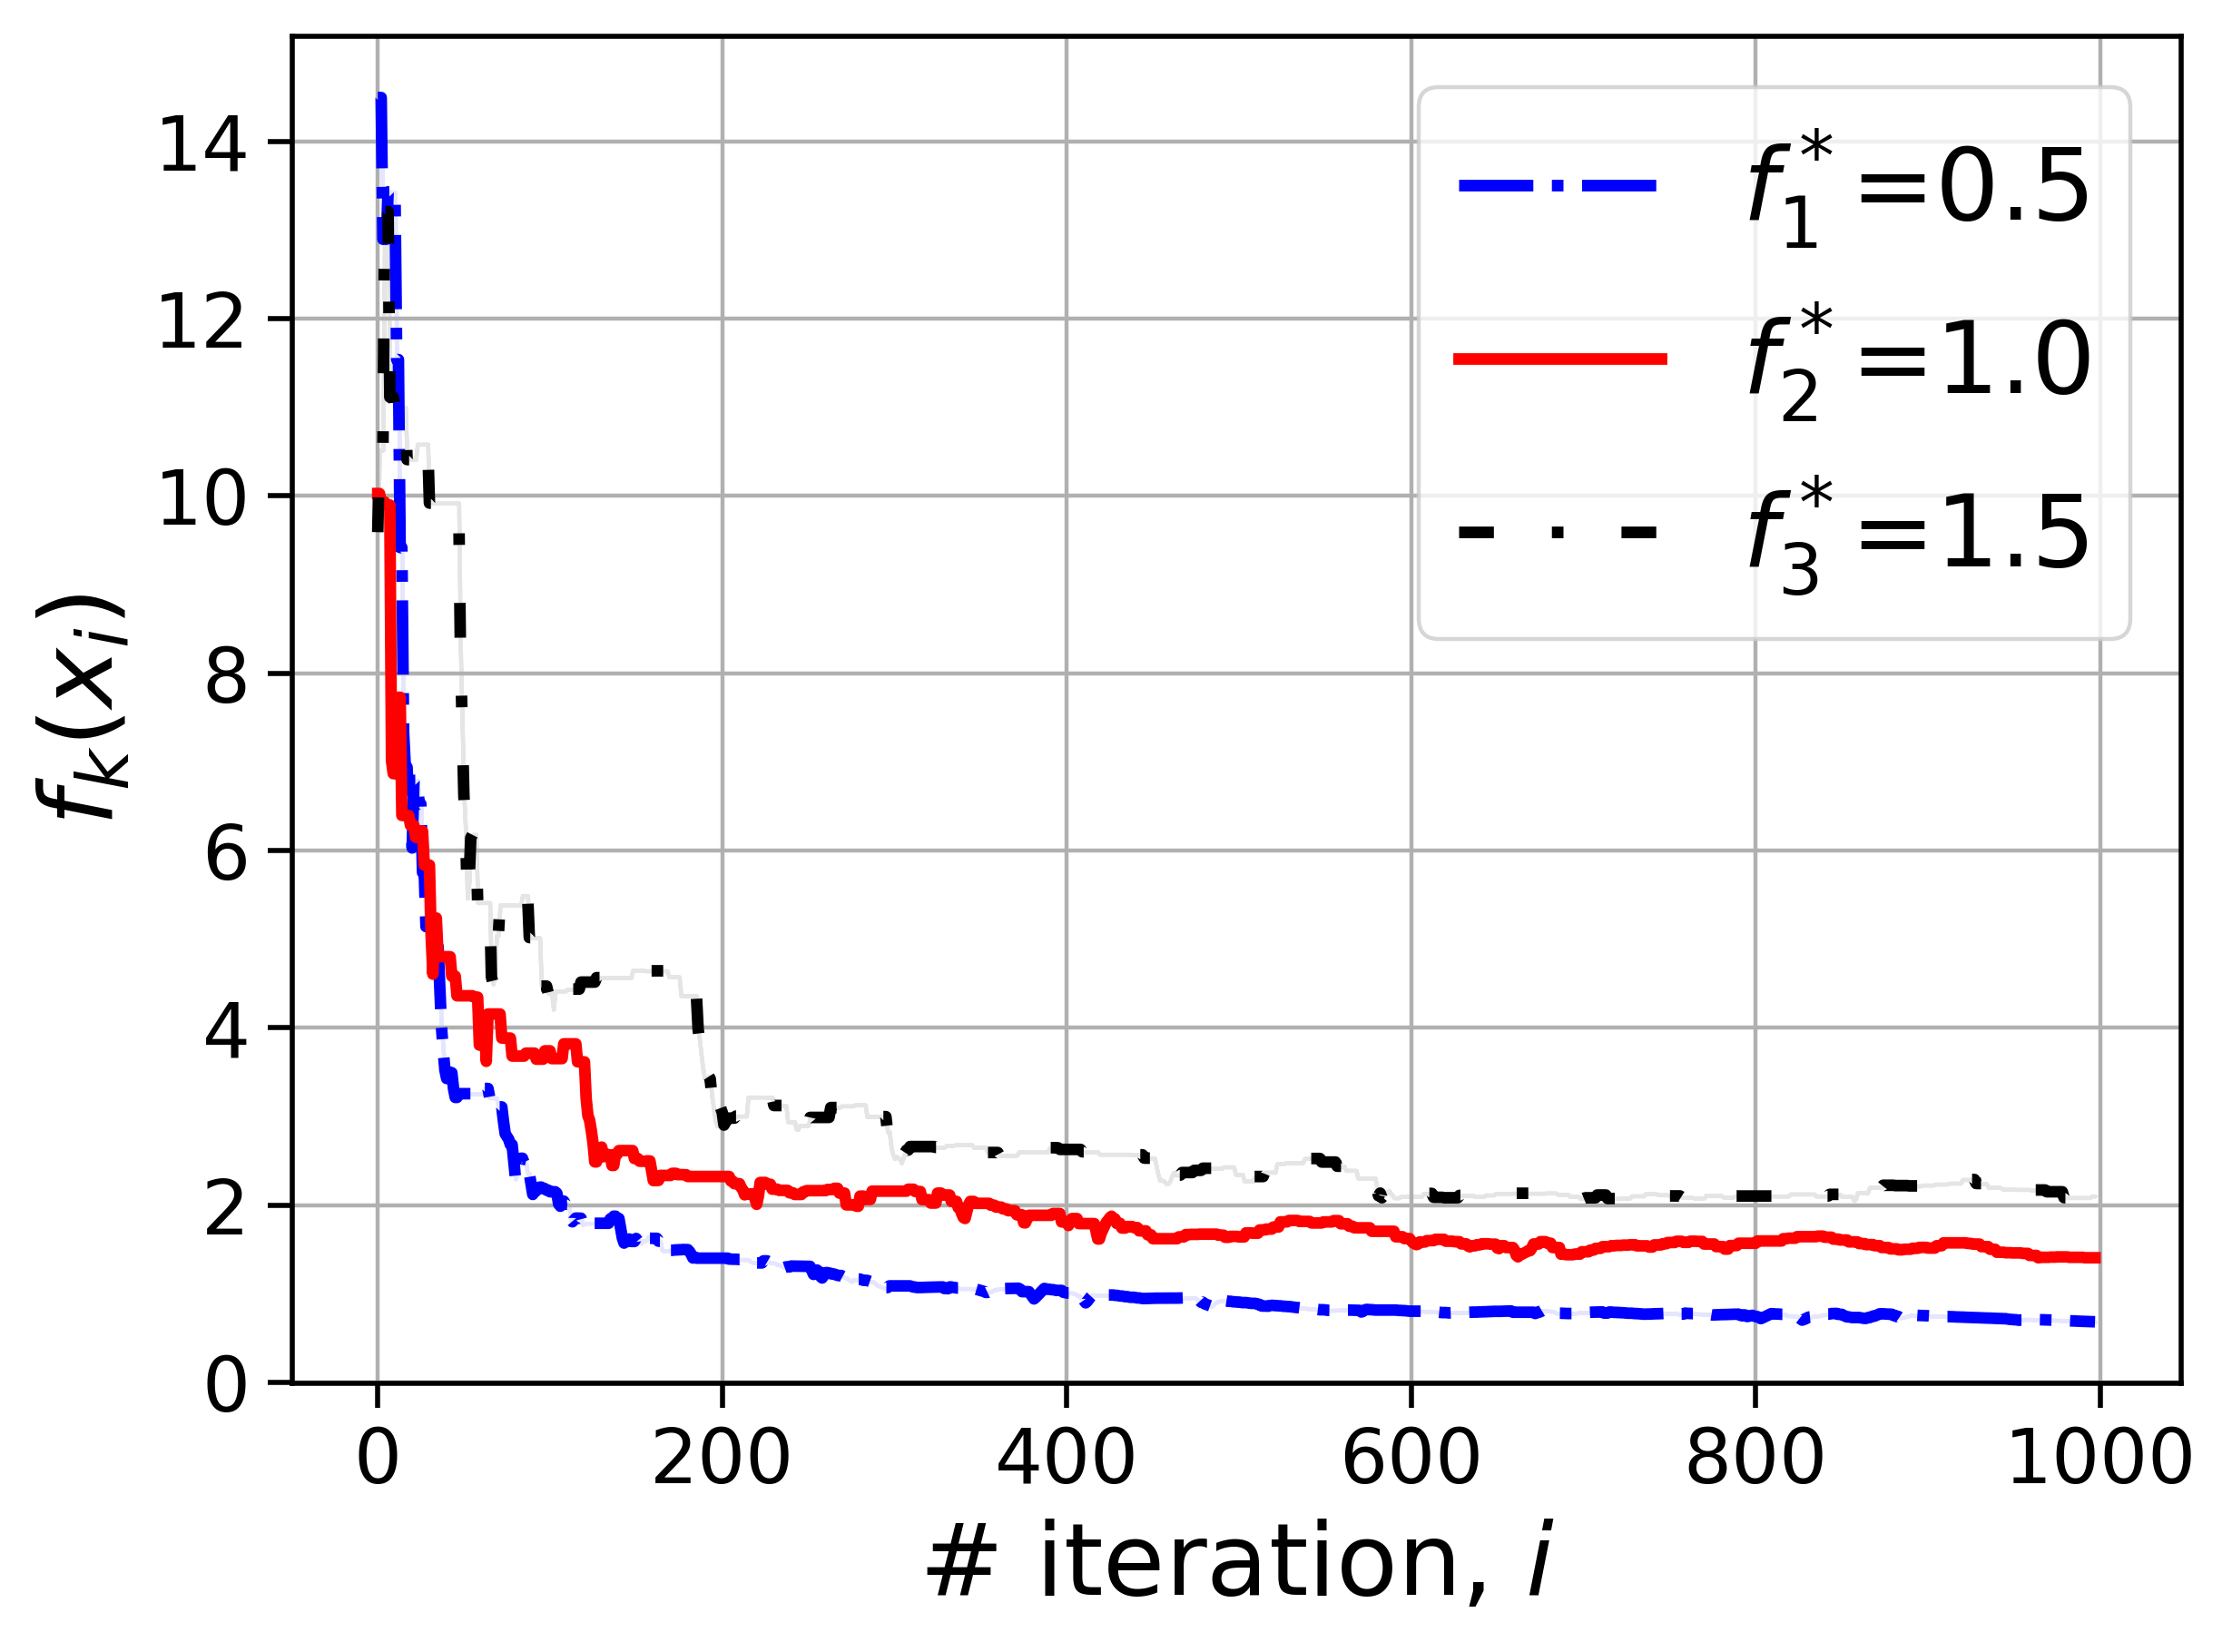

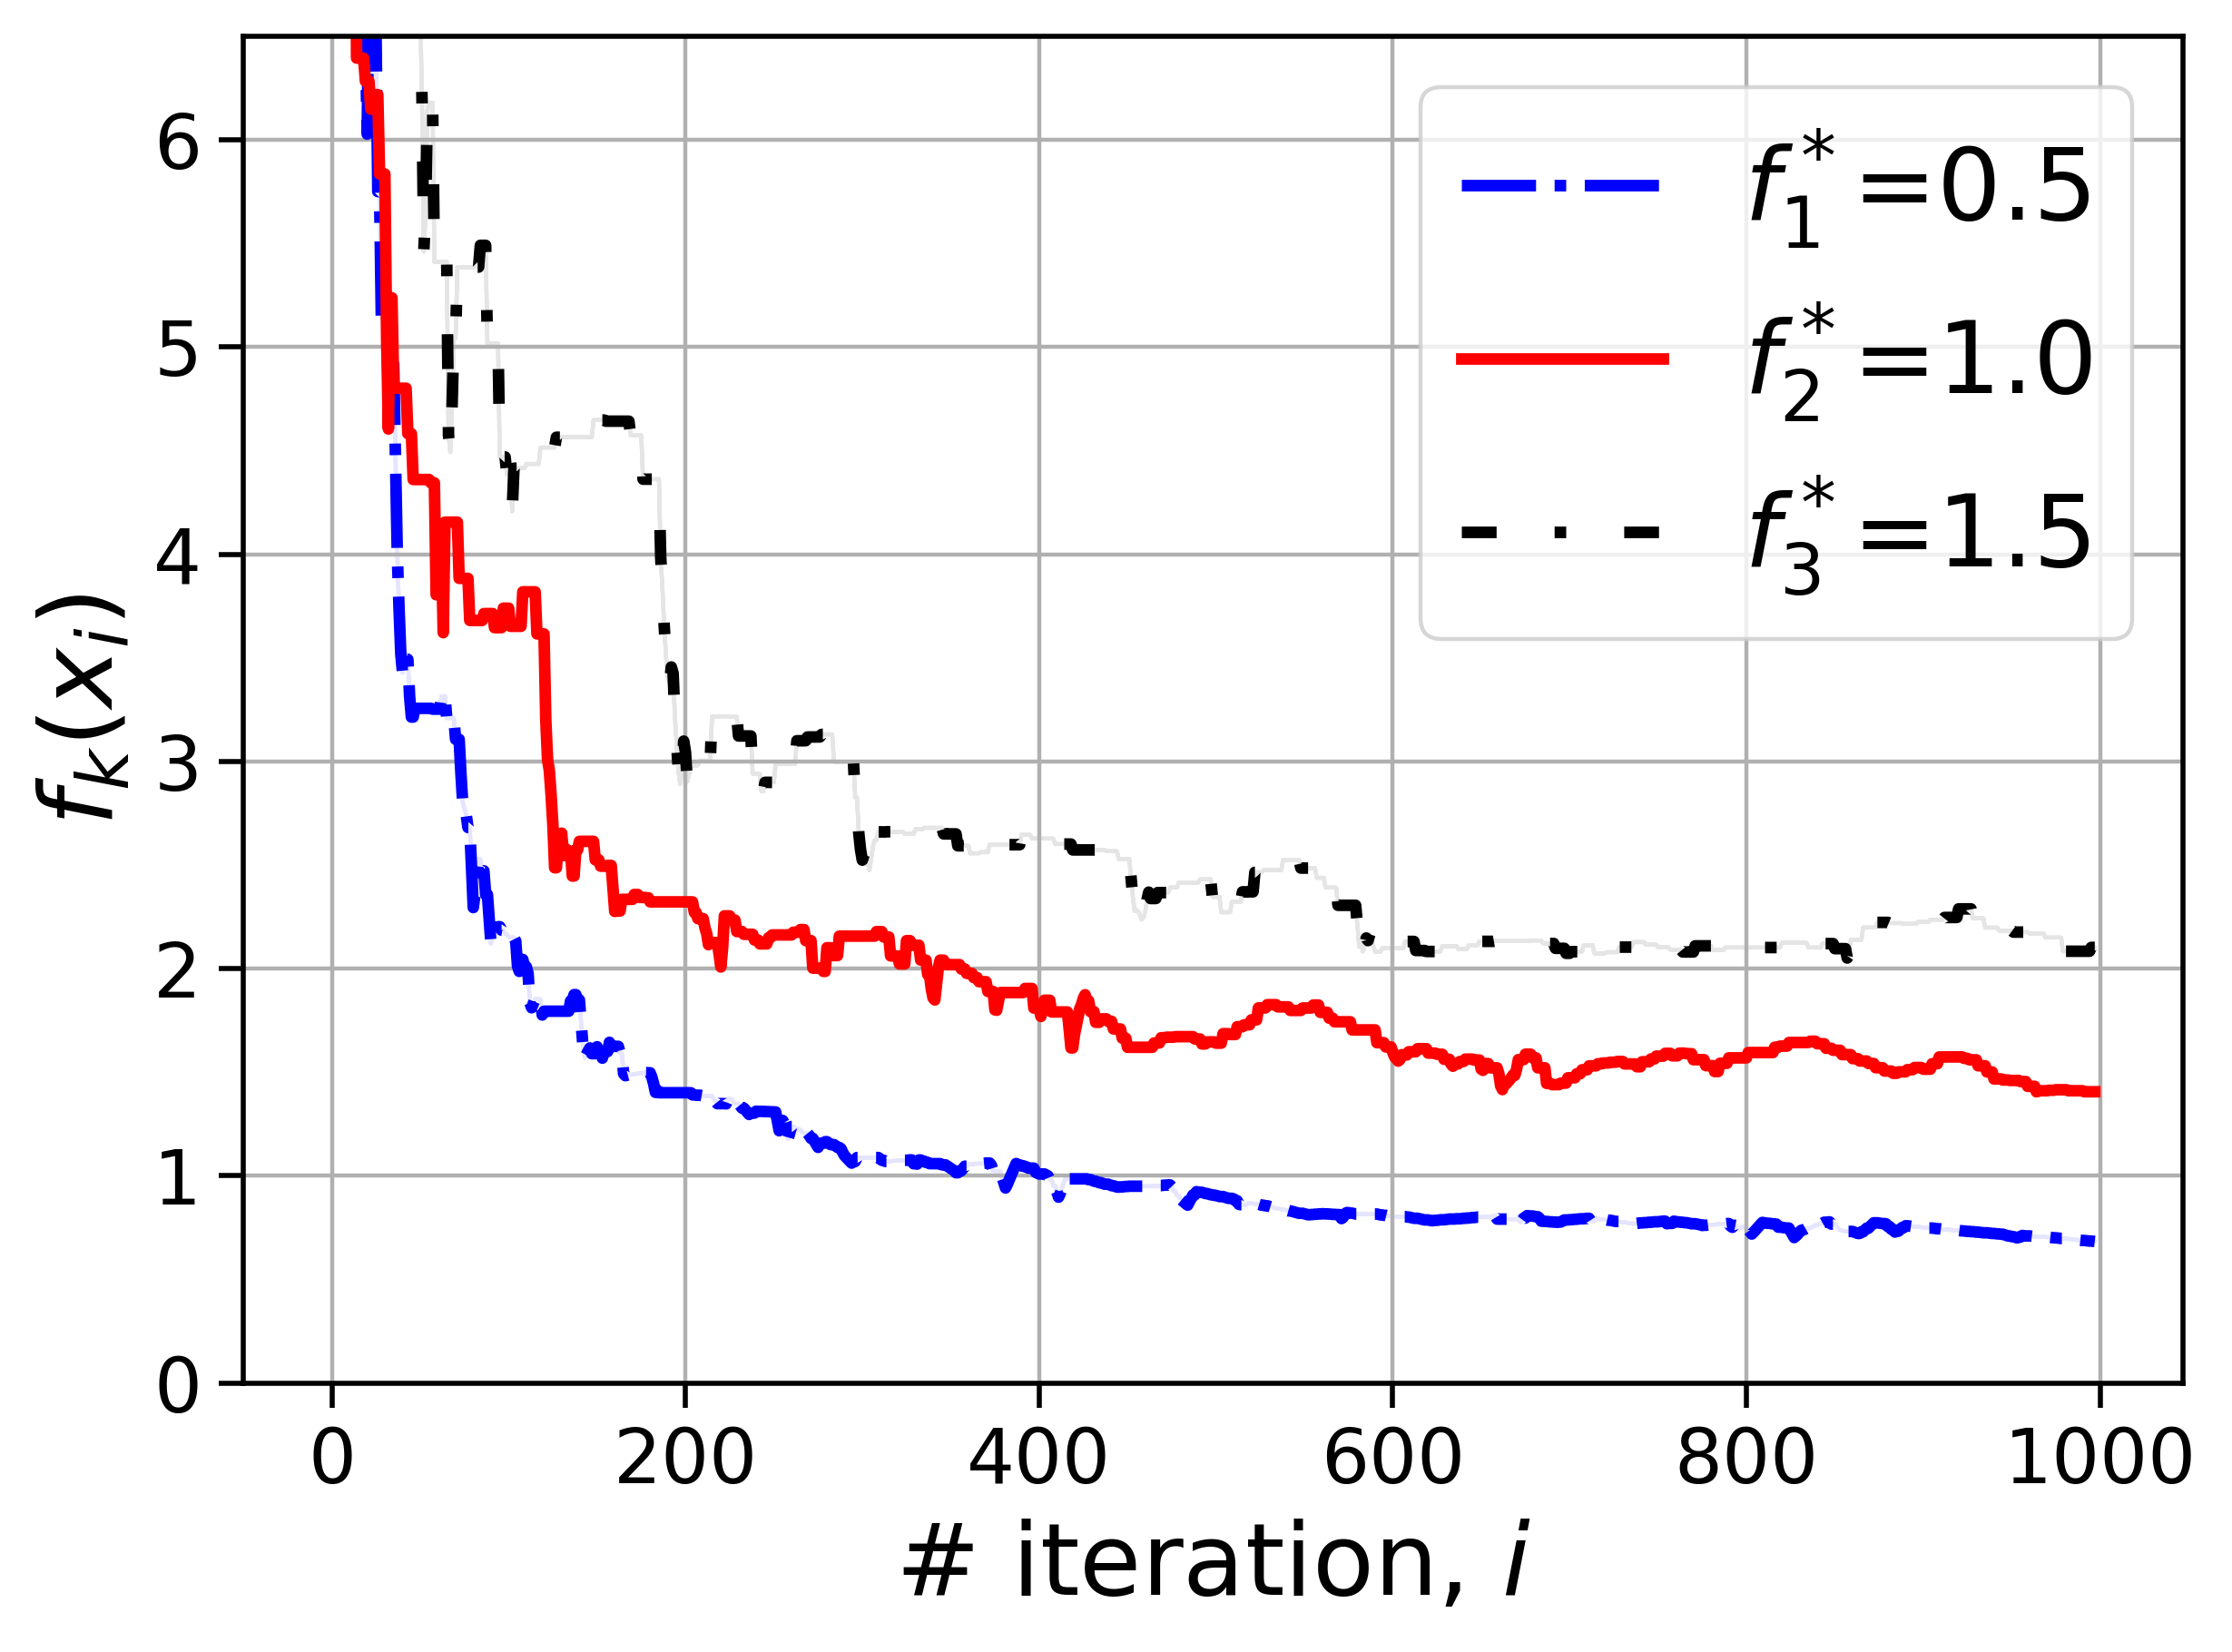

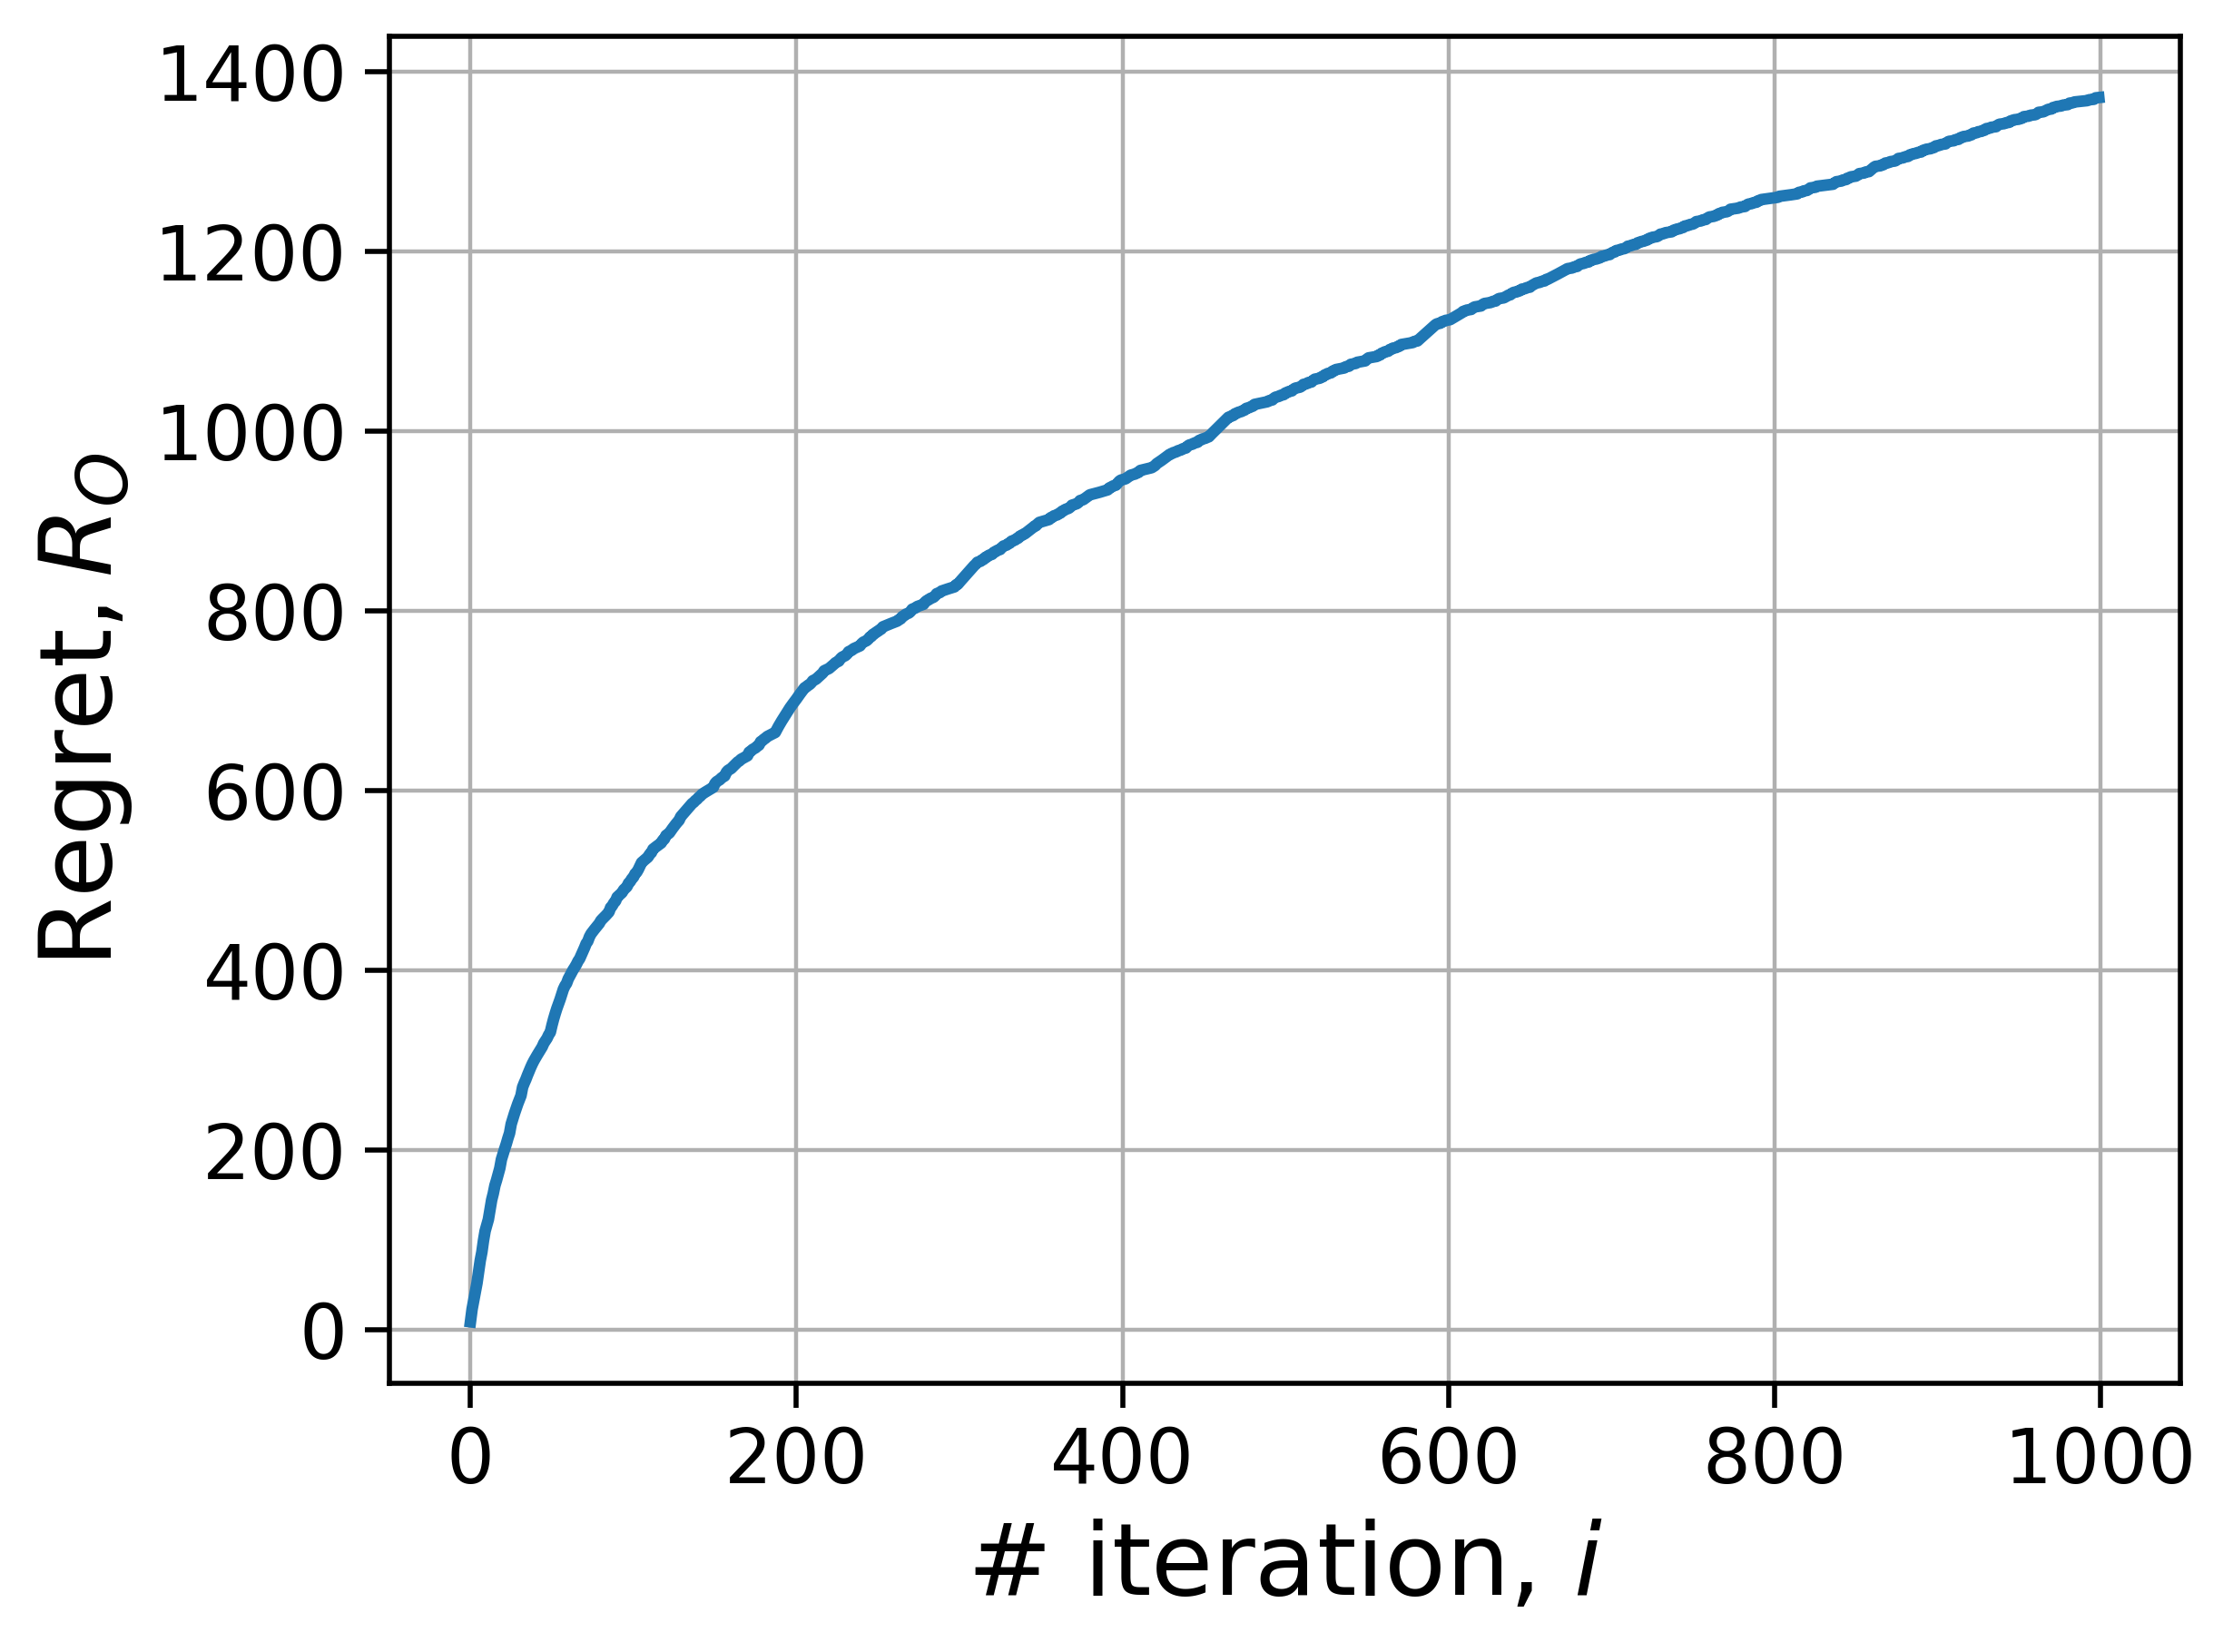

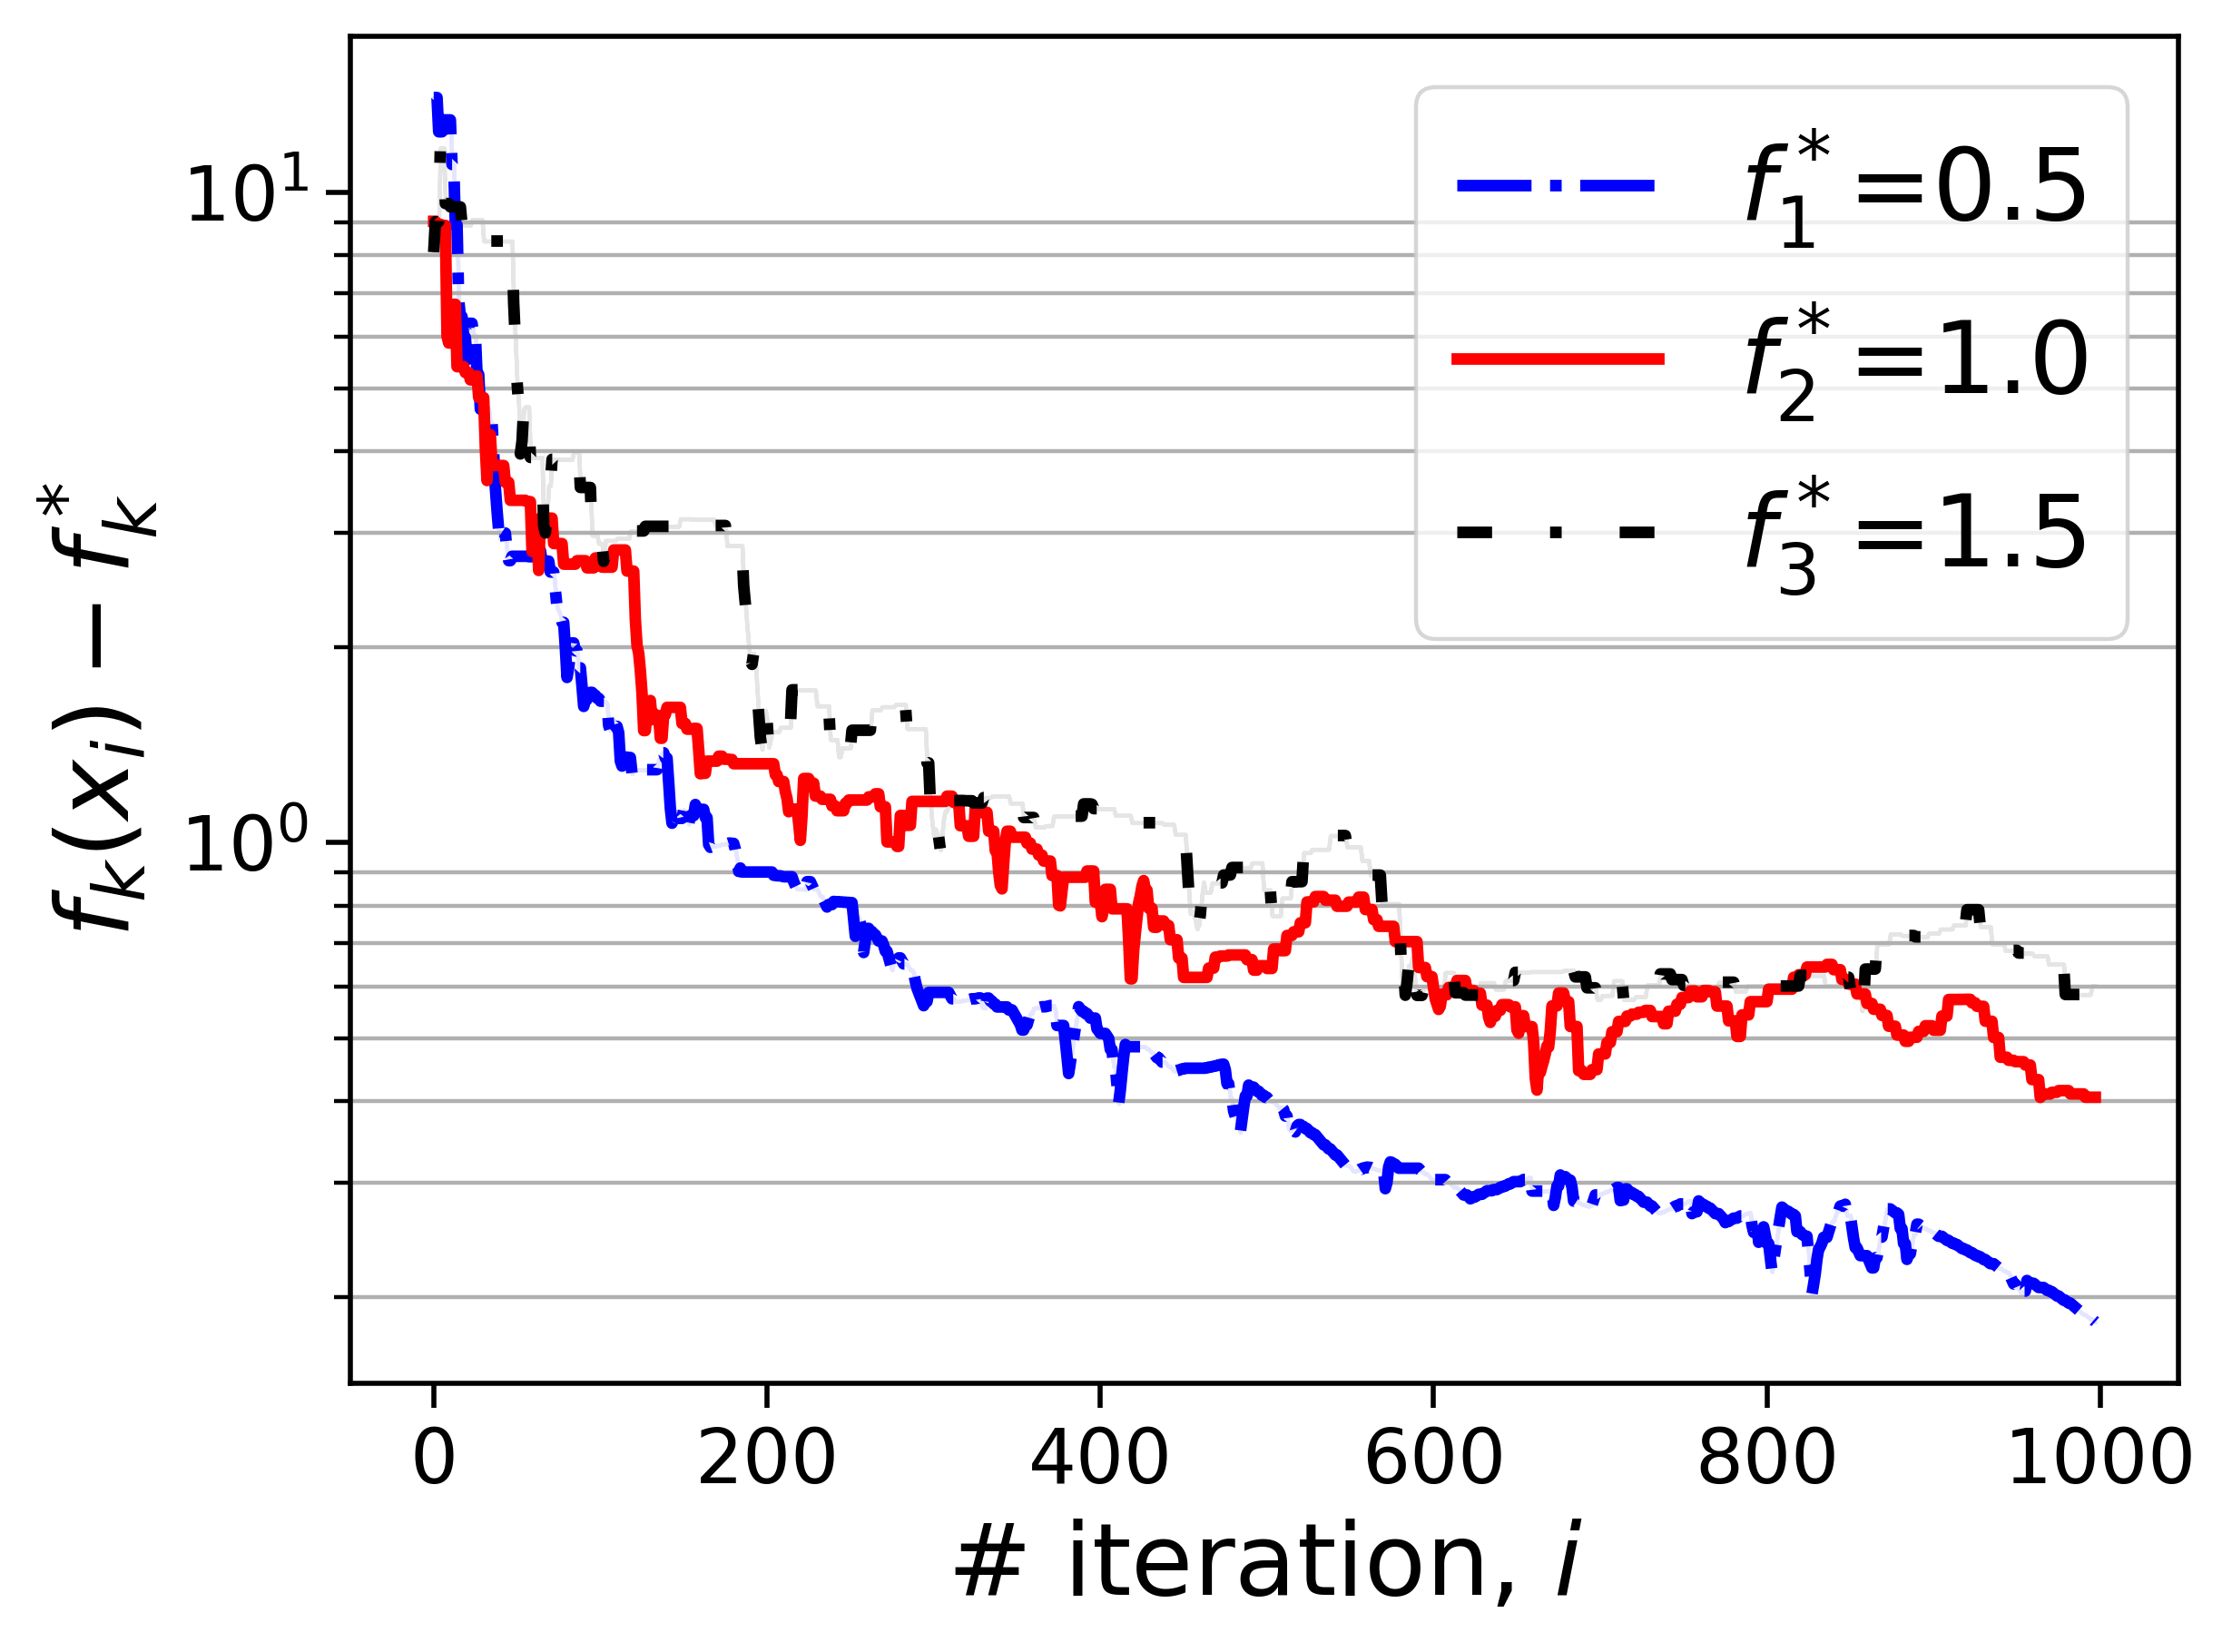

In [17]:
figs = plot_results([res], arms, min_vals, with_intervals=True)
save_figures(figs)

## stochastic arms

here consider multiple start, because this is a stochastic case

In [18]:
raise ValueError

ValueError: 

In [19]:
from multiobjective_opt.synthetic_exp.optimizers import StochasticAGD
from multiobjective_opt.synthetic_exp.function_handler import NormalVectRandomizer
from multiobjective_opt.synthetic_exp.functions import (
    ModularFunc,
    QuadFormSQRT,
)

def get_stochastic_arm(dim_smooth, min_val=None, sigma=1, seed = 0):
    if min_val is None:
        min_val = np.random.randn()

    bounds = Bounds(-np.ones(dim_smooth) * 7, np.ones(dim_smooth) * 7)
    projection_function = Constraints(bounds=bounds)

    grad_randomizer = NormalVectRandomizer(dim=dim_smooth, sigma=sigma)
    oracle_smooth = JaxFunc(
        # QuadFormNotStrongly(dim_smooth, min_val=min_val),
        QuadFormSQRT(dim_smooth, min_val=min_val, seed = seed, eigval_pow=1),
        dim_smooth,
        grad_randomizer=grad_randomizer,
    )
    k = 1
    x0 = None
    upper_bound  = 10 - min_val*4
    lower_bound = 8 - min_val*4

    assert upper_bound - lower_bound >= 1
    while True:
        x0 = np.ones(dim_smooth) * k + oracle_smooth.func.bias
        val = oracle_smooth.func(x0)
        if val > upper_bound:
            k /= 1.1
        elif val < lower_bound:
            k *= 1.2
        else:  
            # print(np.sum(np.abs(x0) > 5), np.max(np.abs(x0)))
            break
    
    Lipshitz, R = oracle_smooth.func.get_params(x0)
    L = Lipshitz
    D = R
    M = 2

    smooth_optimizer = StochasticAGD(
        oracle_smooth, projection=projection_function, x0=x0, sigma=sigma, L=L, D=D, M=M
    )
    arm = FuncArm(smooth_optimizer)
    arm.name = rf"$f_{int(min_val * 2)}^*$={(min_val)}" #, $\sigma=${sigma}"
    return arm


def init_arms(nonsmooth_arms):
    dim = 20
    nonsmooth_arms = 3

    nonsmooth_arms_values = np.array([0.5,1,1.5])
    sigmas = np.array([2, 2, 2])

    arms = []

    for i in range(nonsmooth_arms):
        seed = int(nonsmooth_arms_values[i] *2 +  17 * sigmas[i])
        nsm_opt = get_stochastic_arm(dim, nonsmooth_arms_values[i], sigma=sigmas[i], seed = seed)
        arms.append(nsm_opt)

    return arms, nonsmooth_arms_values

In [20]:

from joblib import Parallel, delayed

num_runs = 20
n_actions = 3
arms, min_vals = init_arms(n_actions)

def run_alg():

    reward_estimator = FuncRewardEstimator(n_actions)
    agent = UCB(n_actions, reward_estimator)

    arms, min_vals = init_arms(n_actions)
    env = ArmEnv(arms)

    runner = RunAlgEnv(env, agent)
    res = runner.run(max_steps=1500)
    return res
del_run = delayed(run_alg)
results = Parallel(20)(del_run() for _ in range(num_runs))

[<class 'multiobjective_opt.synthetic_exp.drawer.PlottableRes'>, <class 'multiobjective_opt.synthetic_exp.drawer.PlottableRes'>, <class 'multiobjective_opt.synthetic_exp.drawer.PlottableRes'>, <class 'multiobjective_opt.synthetic_exp.drawer.PlottableRes'>, <class 'multiobjective_opt.synthetic_exp.drawer.PlottableRes'>, <class 'multiobjective_opt.synthetic_exp.drawer.PlottableRes'>, <class 'multiobjective_opt.synthetic_exp.drawer.PlottableRes'>, <class 'multiobjective_opt.synthetic_exp.drawer.PlottableRes'>, <class 'multiobjective_opt.synthetic_exp.drawer.PlottableRes'>, <class 'multiobjective_opt.synthetic_exp.drawer.PlottableRes'>, <class 'multiobjective_opt.synthetic_exp.drawer.PlottableRes'>, <class 'multiobjective_opt.synthetic_exp.drawer.PlottableRes'>, <class 'multiobjective_opt.synthetic_exp.drawer.PlottableRes'>, <class 'multiobjective_opt.synthetic_exp.drawer.PlottableRes'>, <class 'multiobjective_opt.synthetic_exp.drawer.PlottableRes'>, <class 'multiobjective_opt.synthetic_ex

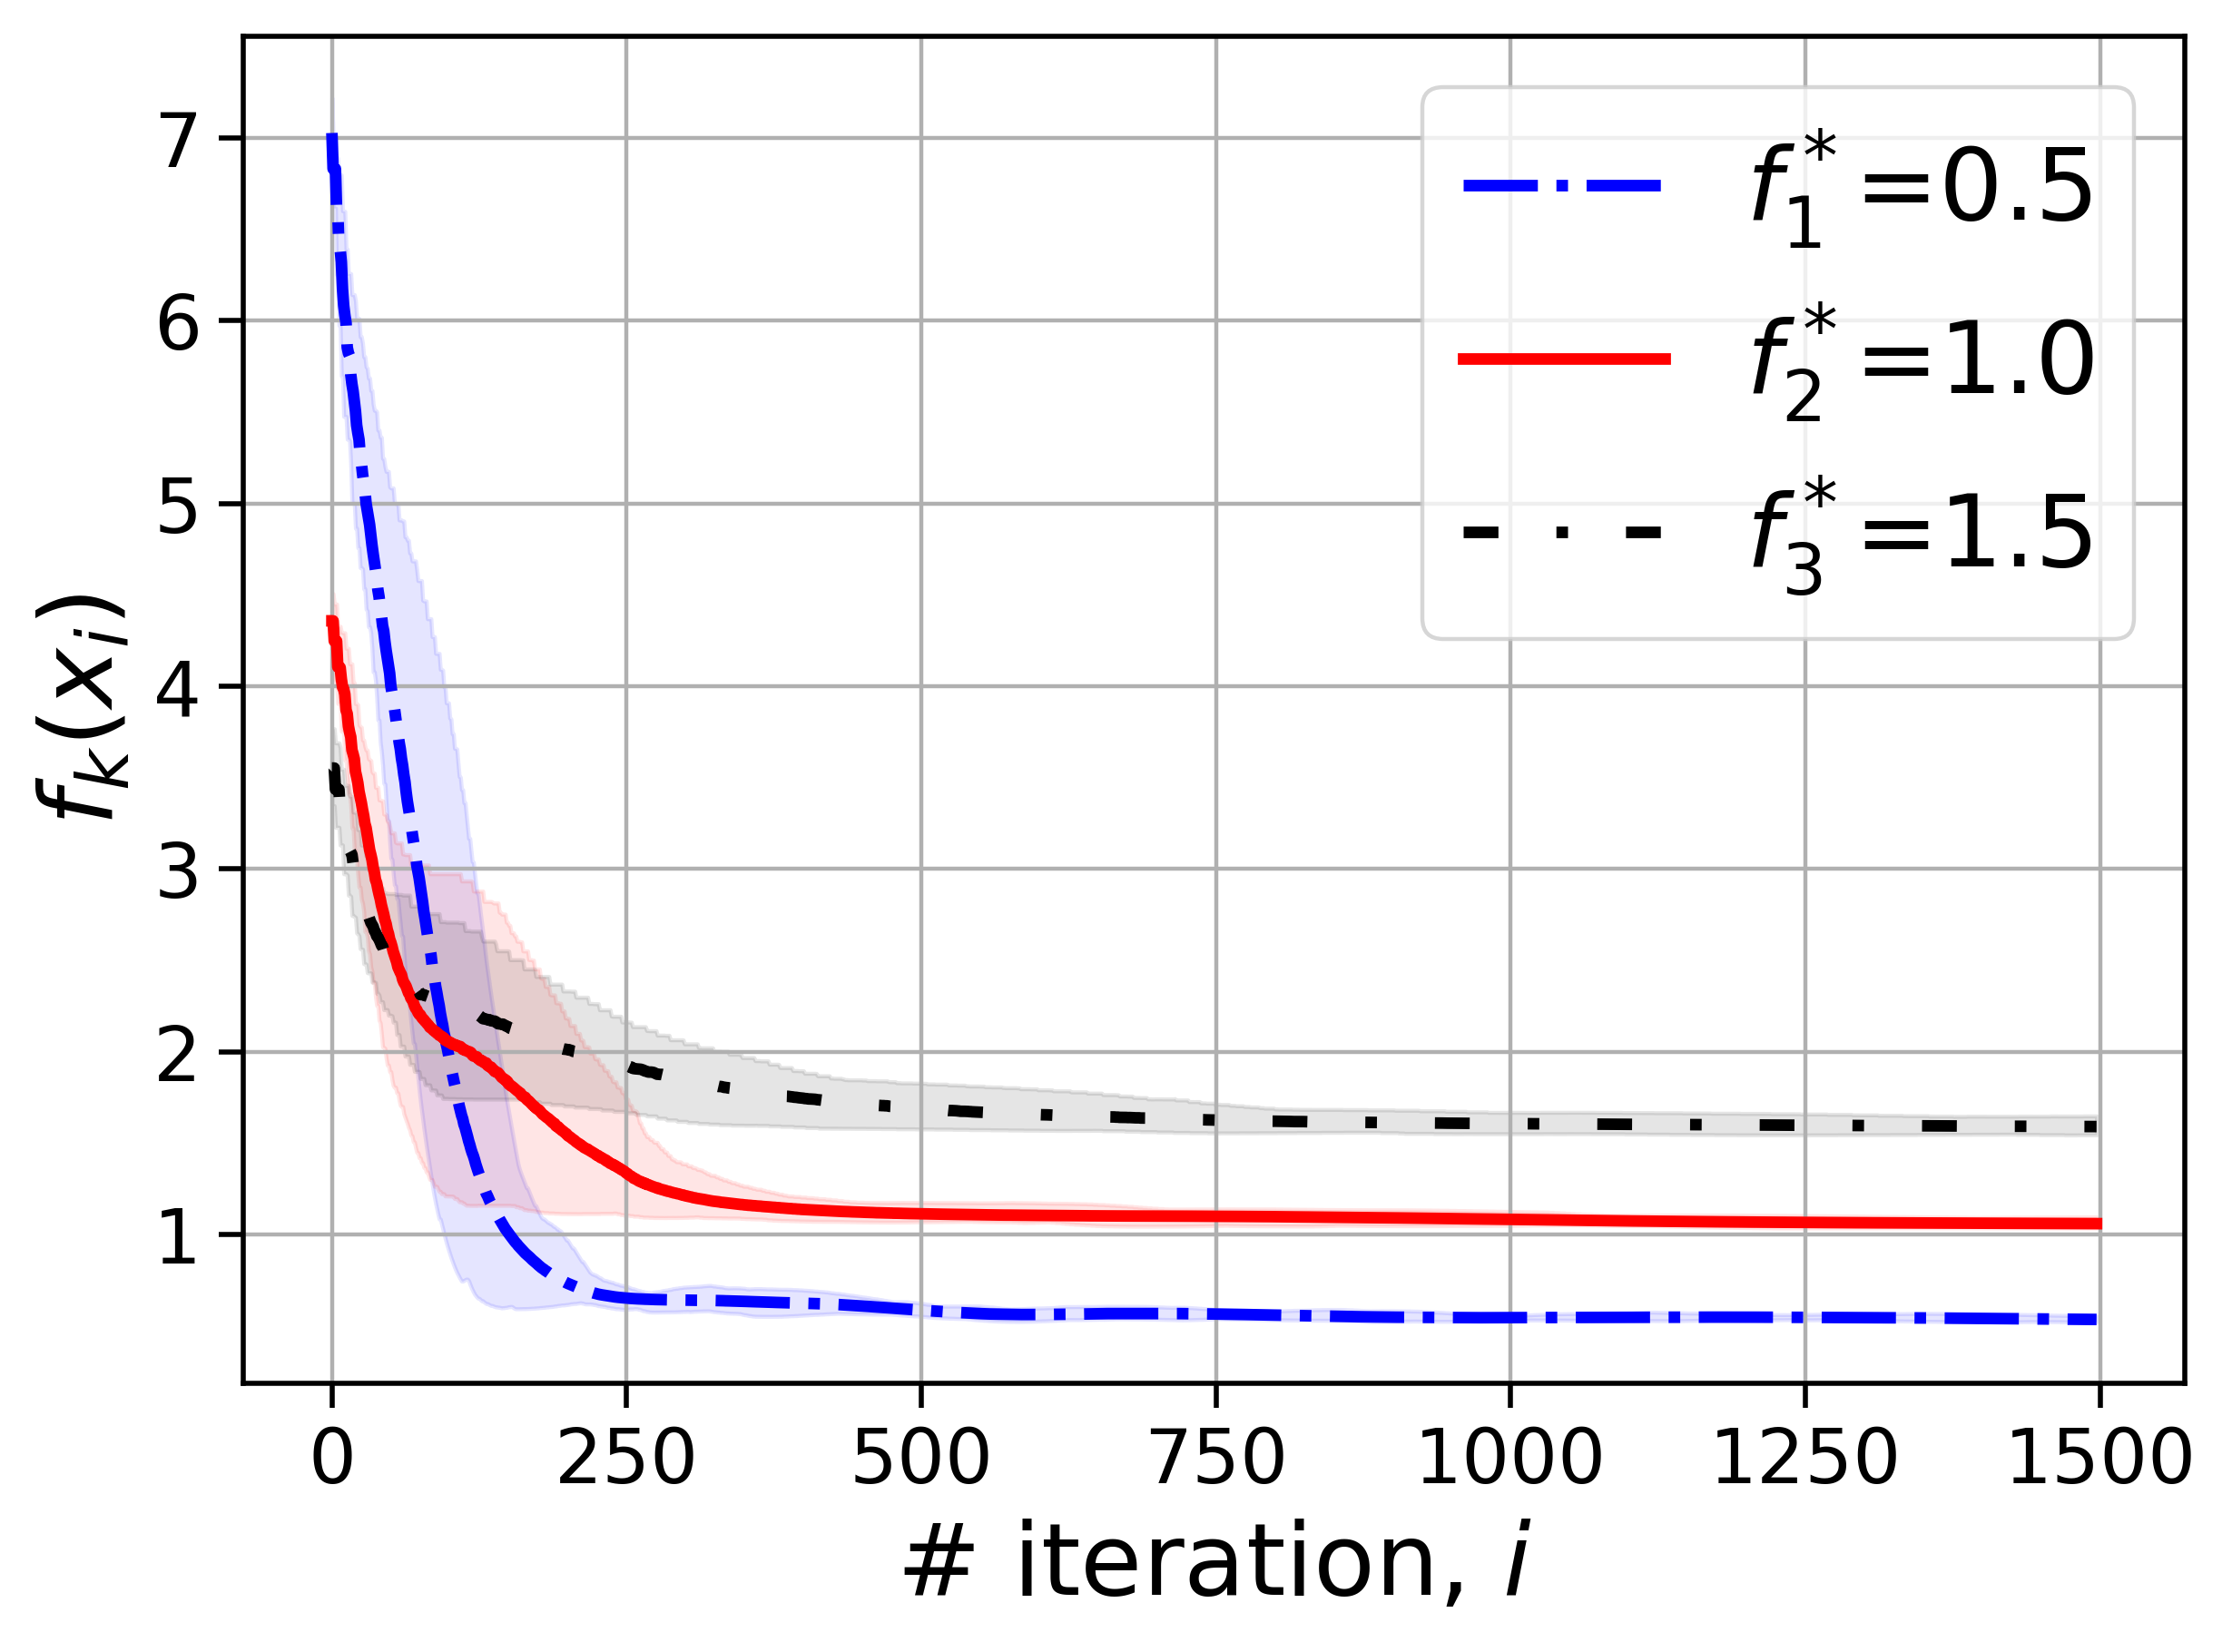

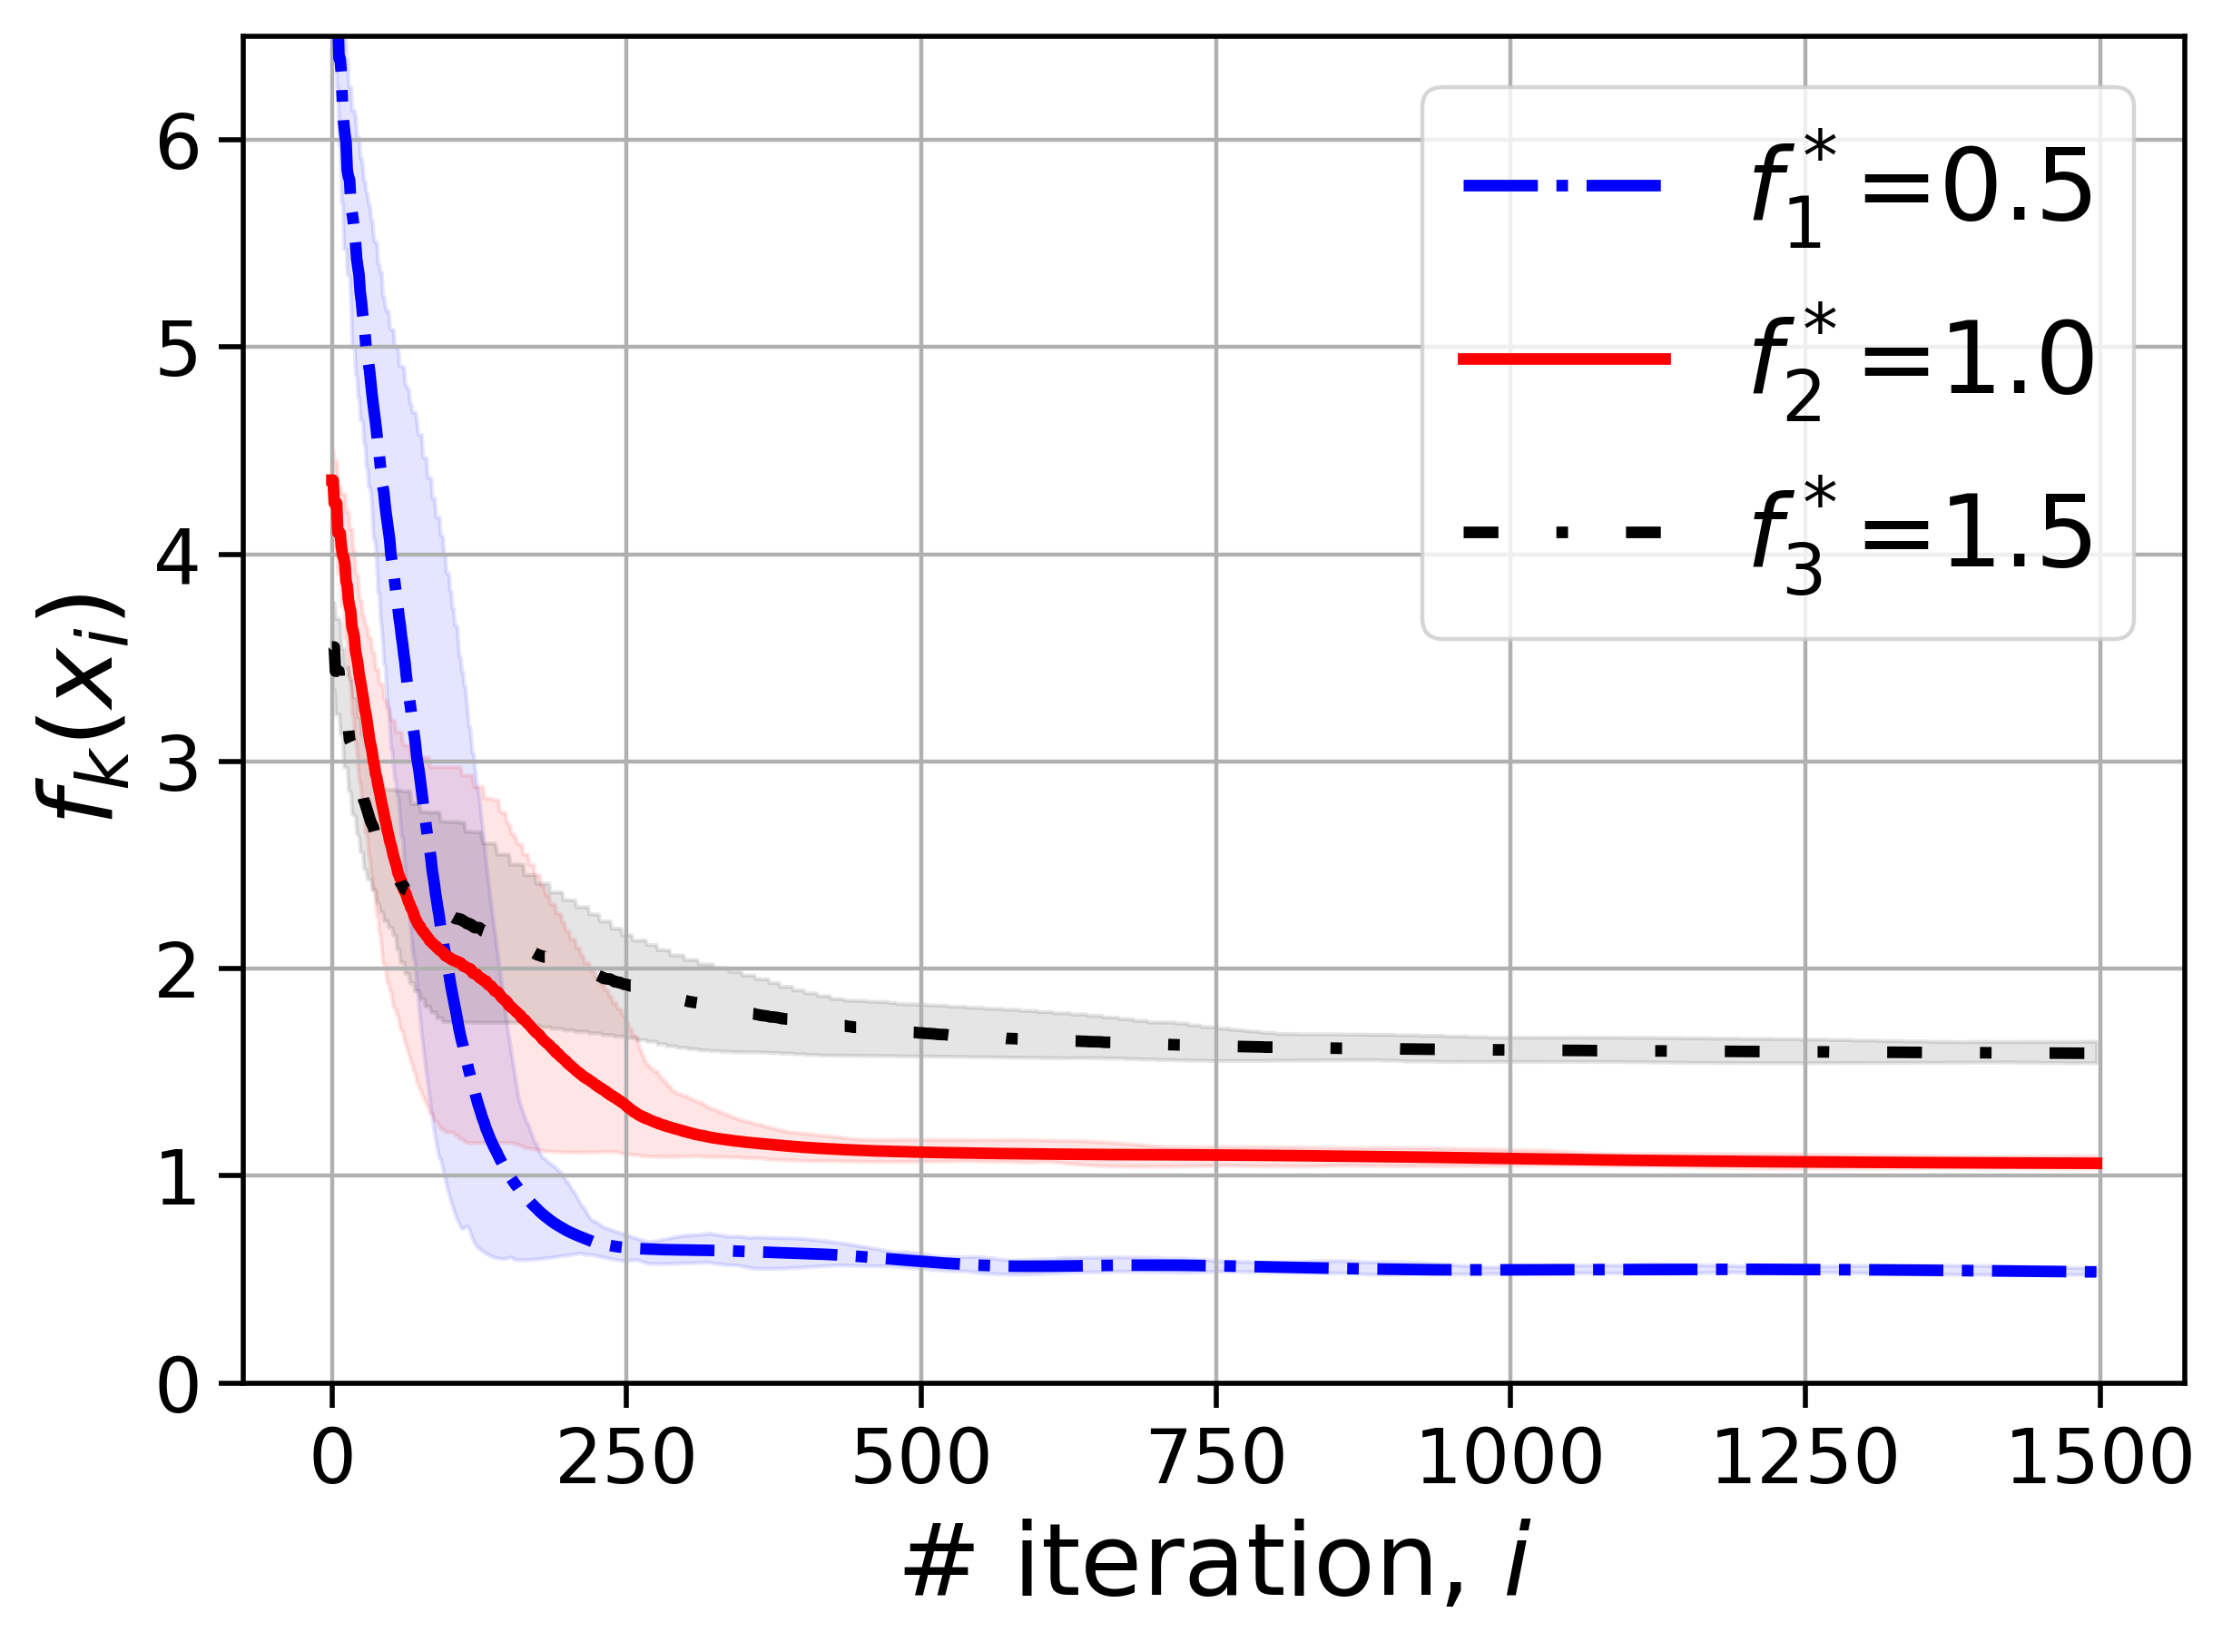

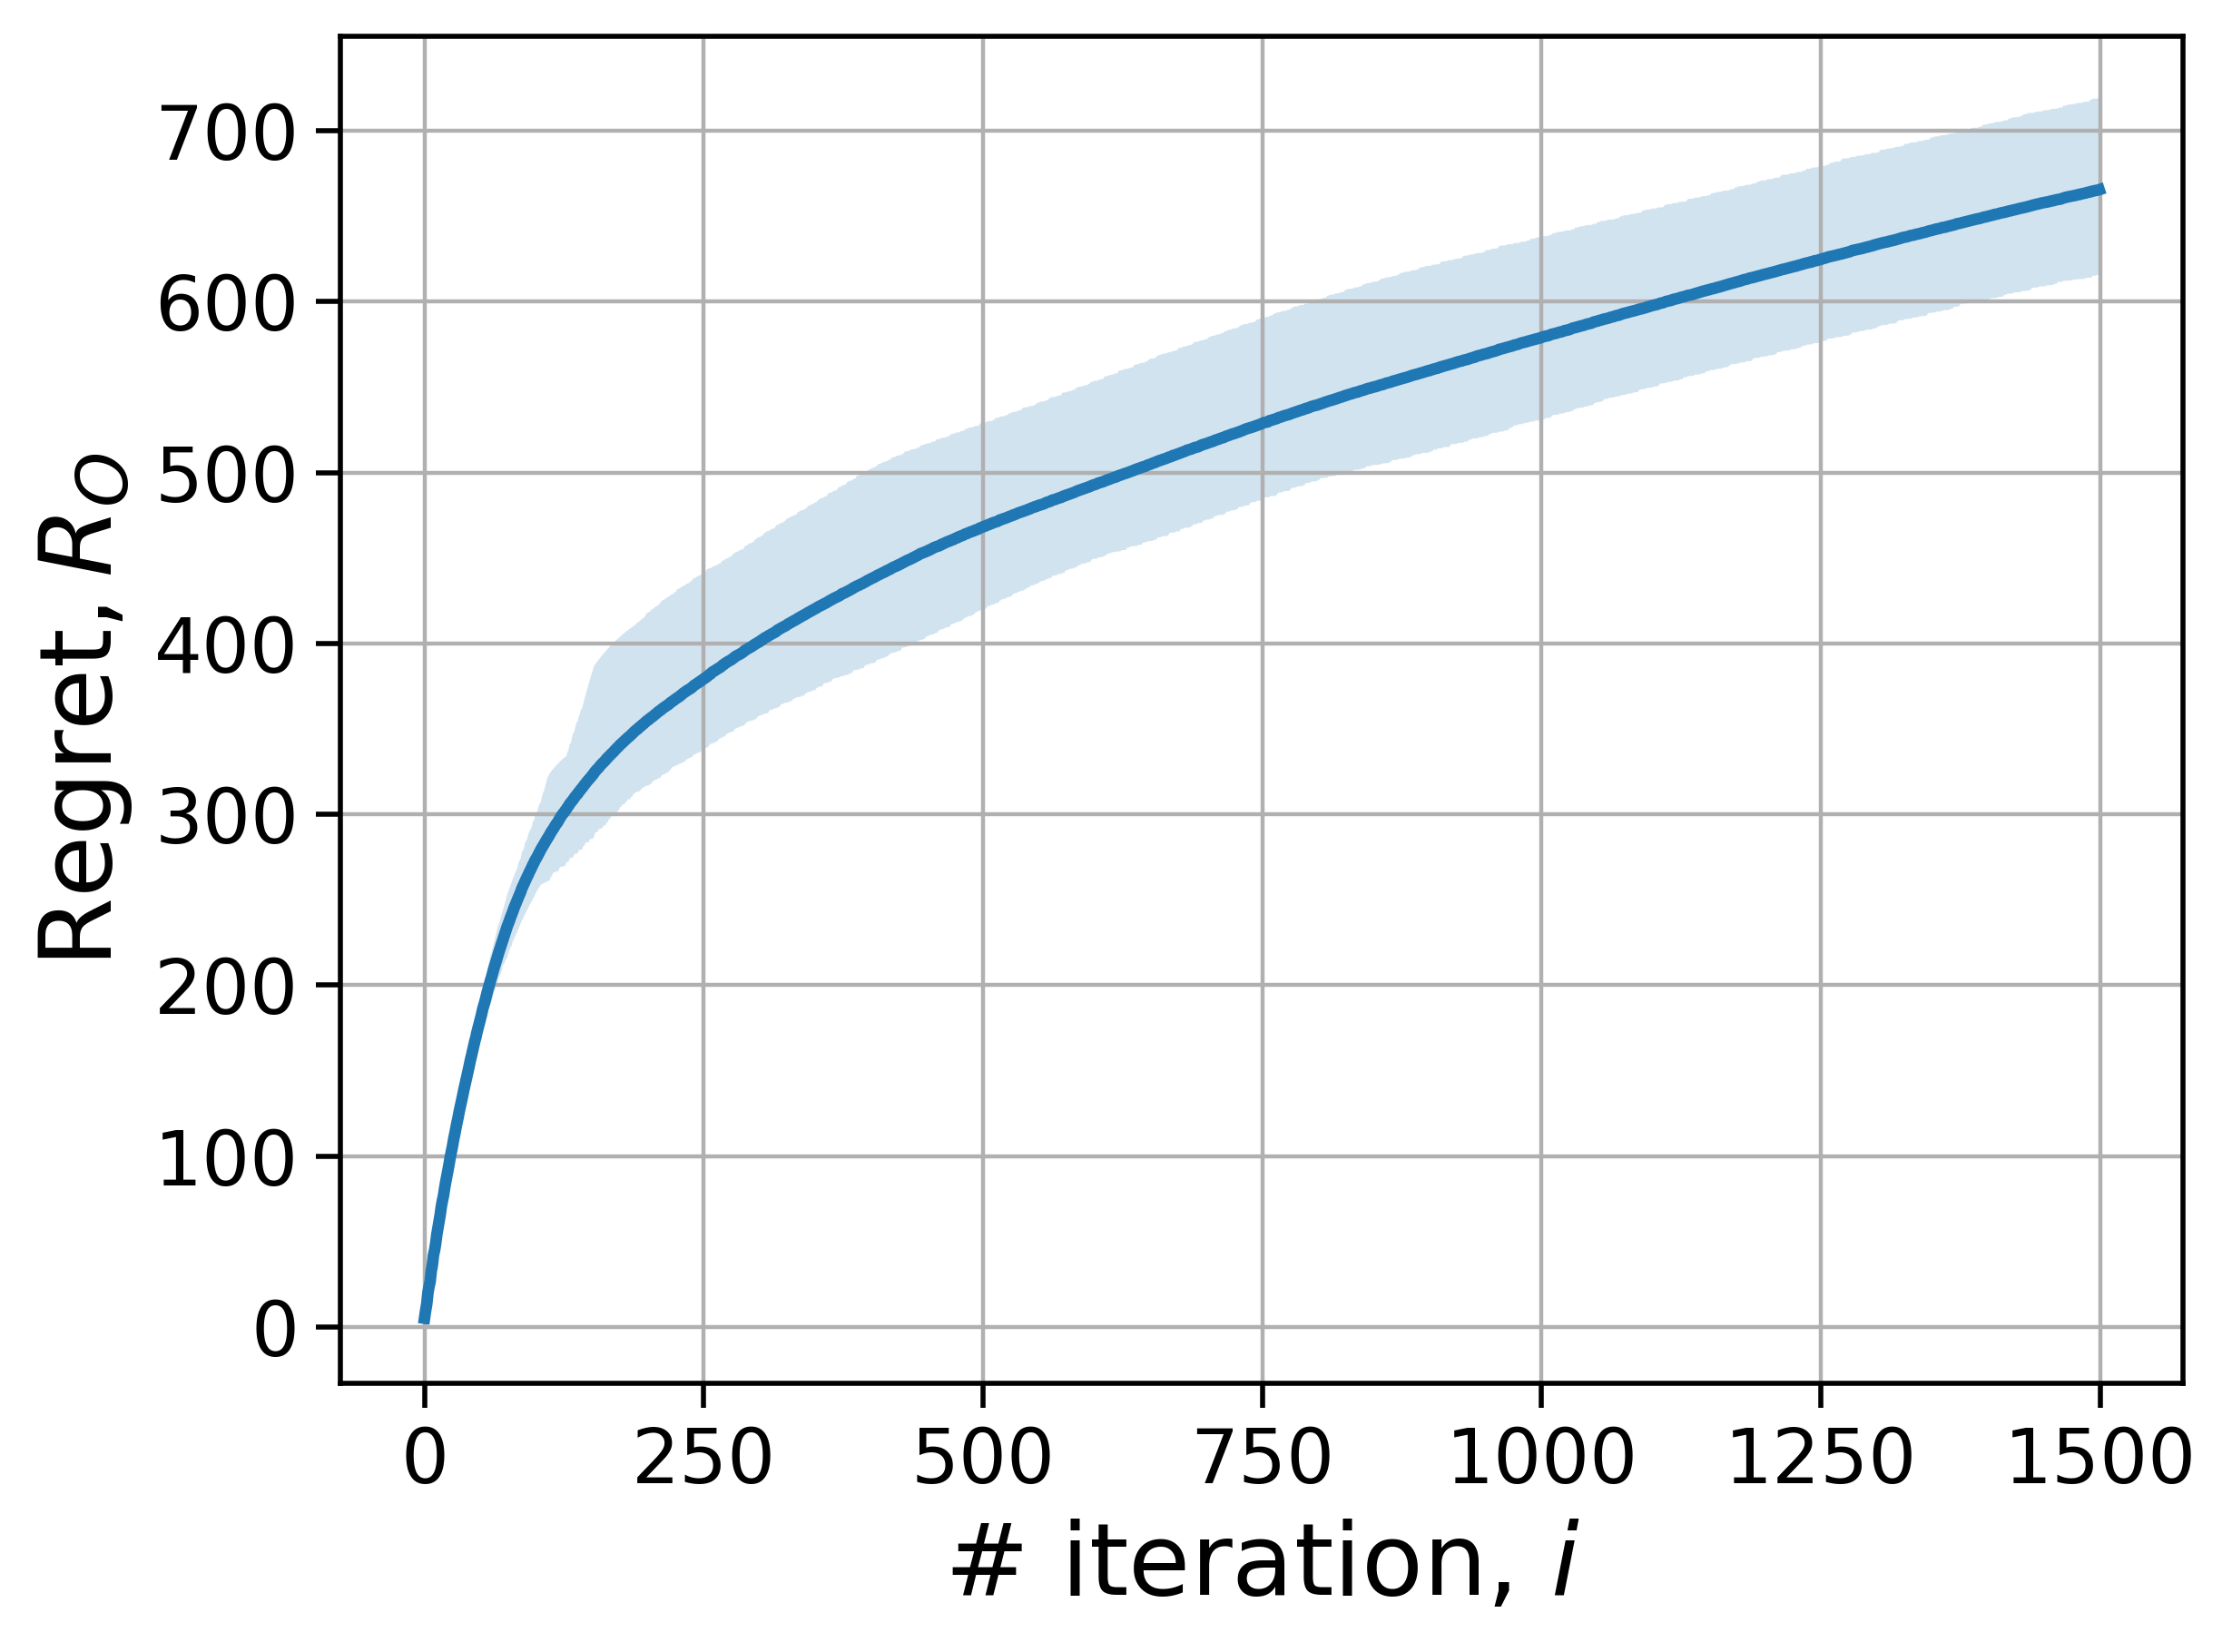

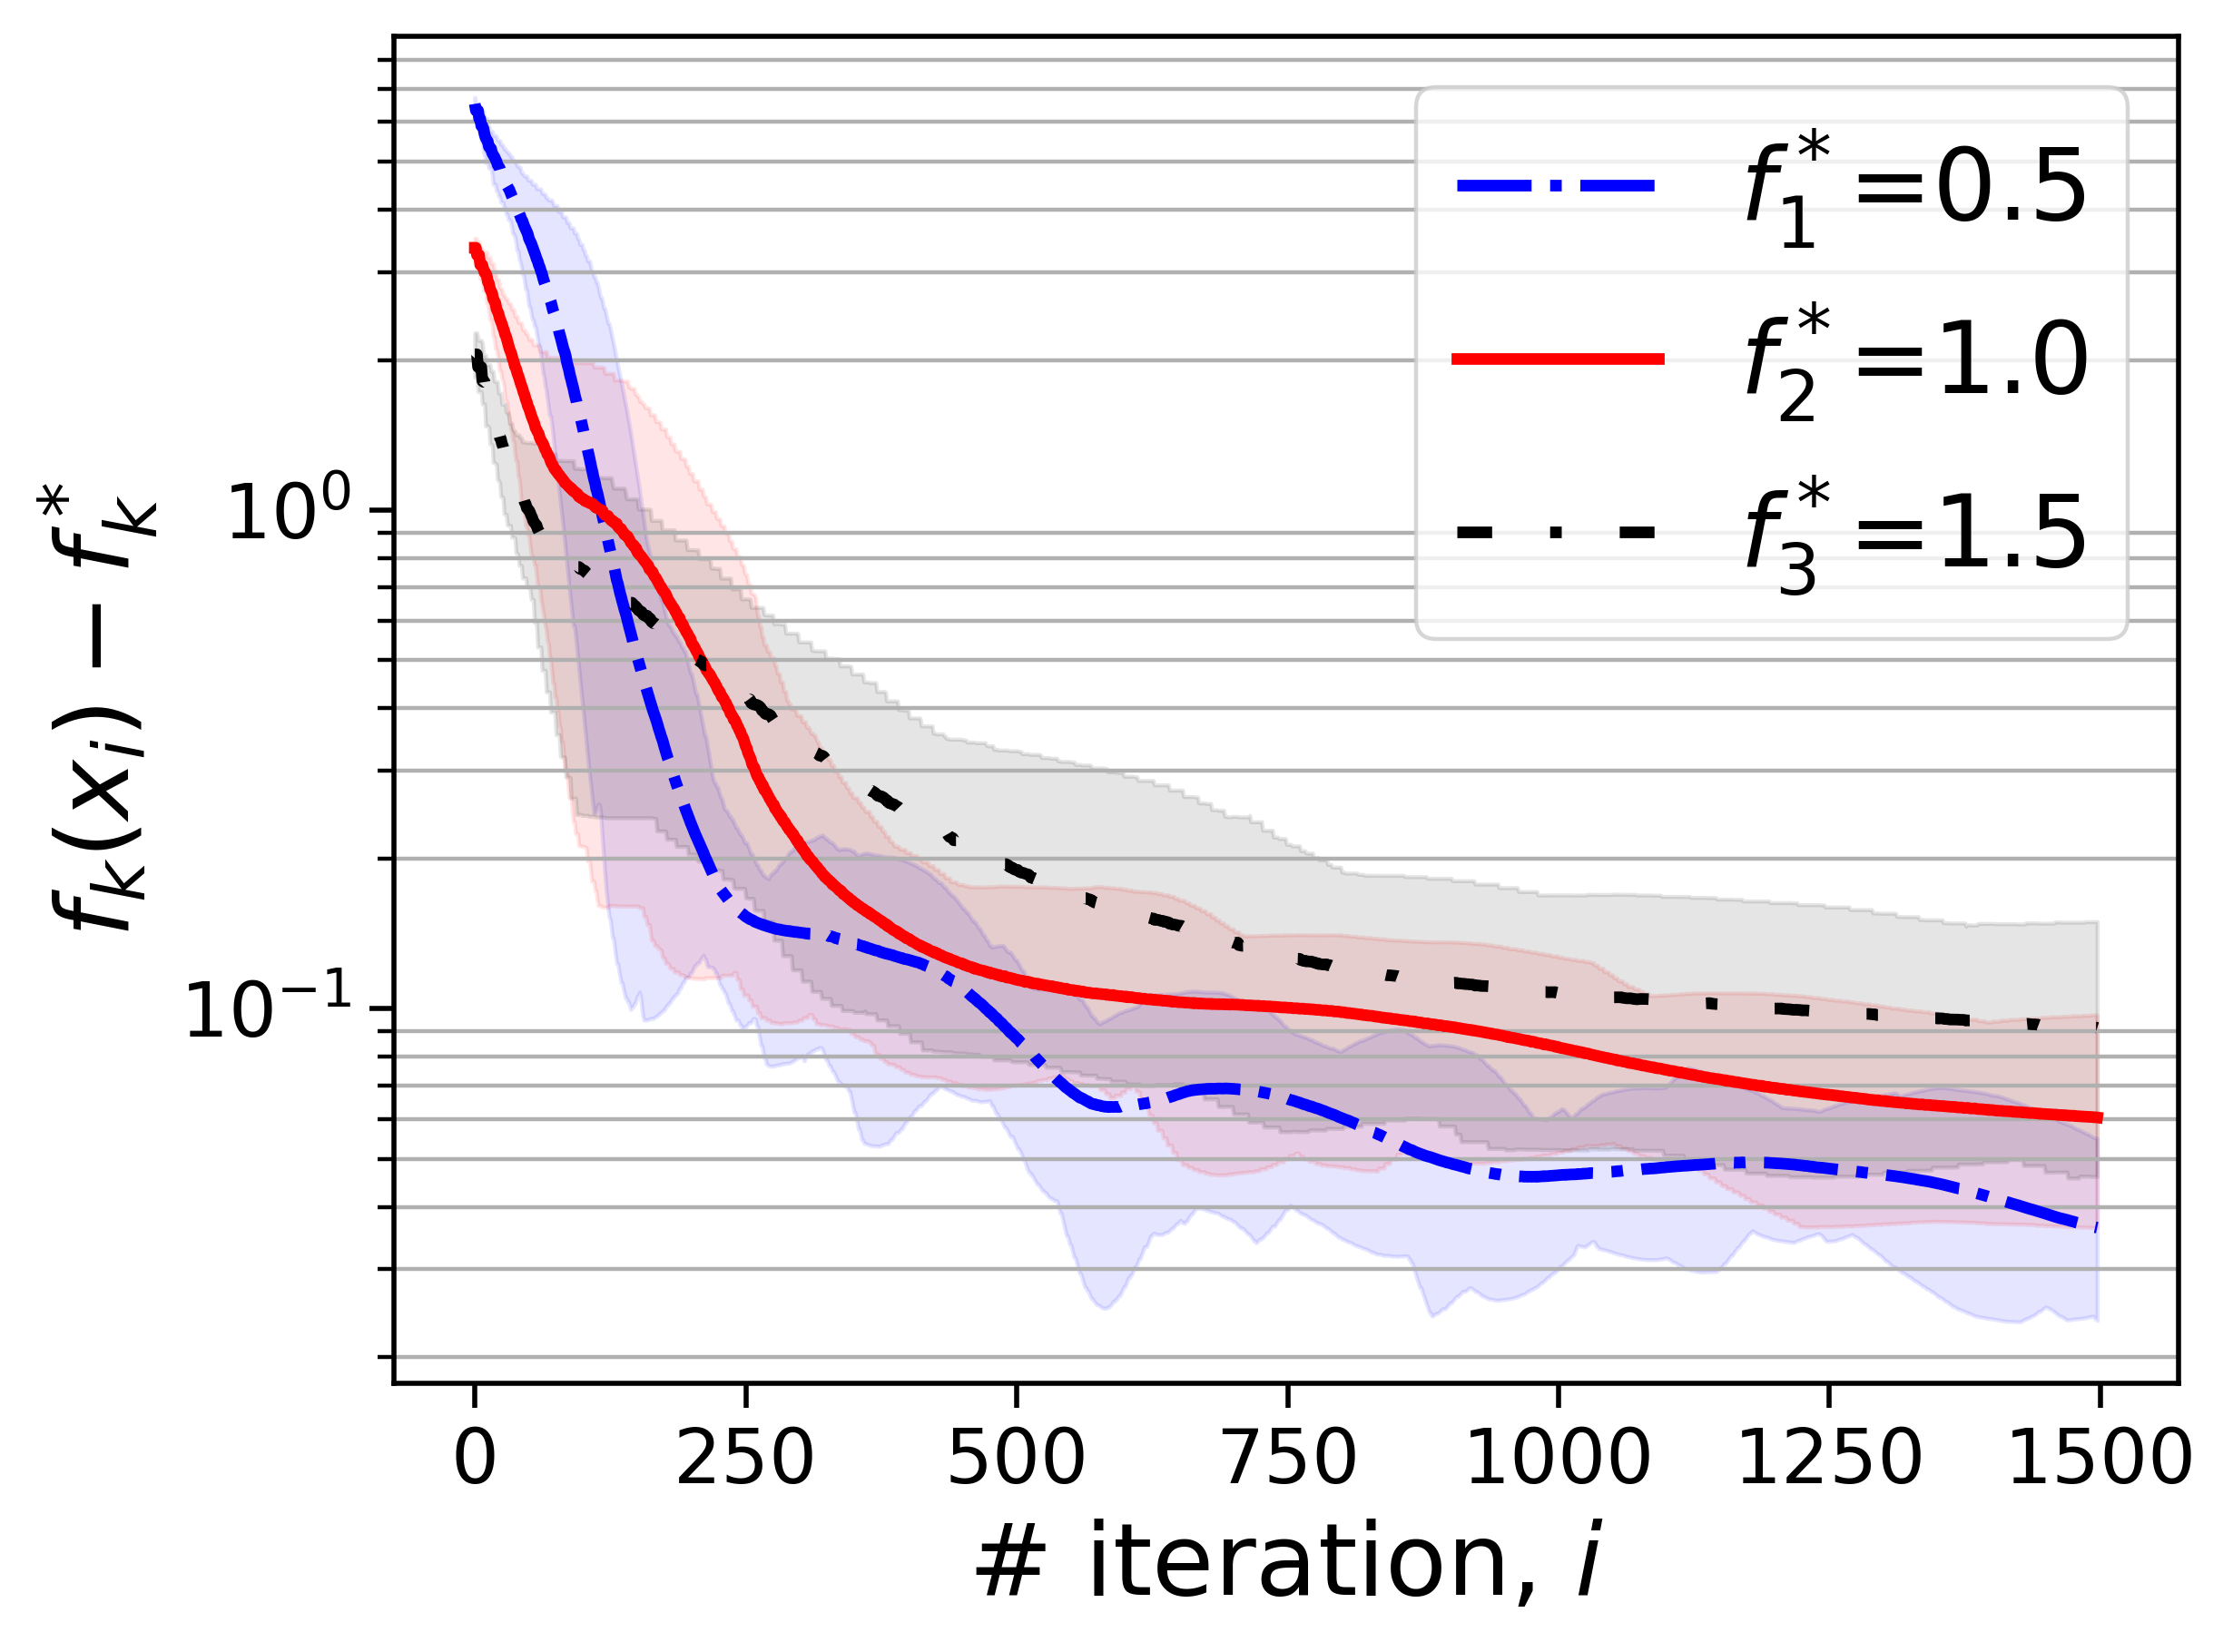

In [21]:
figs = plot_results(results, arms, min_vals, with_intervals=True)
save_figures(figs)